In [1]:
import pathlib
import pickle

import cmasher as cmr
import astropy.table as at
import astropy.units as u
import jax
import matplotlib as mpl
import matplotlib.pyplot as plt
import gala.potential as gp
import h5py
import numpy as np
from gala.units import galactic
import torusimaging as oti
from torusimaging_helpers.config import cache_path

jax.config.update("jax_enable_x64", True)

In [2]:
name = "gaia-spiral"

pdata_file = pathlib.Path(cache_path / f"{name}-pdata.hdf5")
bdata_file = pathlib.Path(cache_path / f"{name}-bdata.hdf5")

In [3]:
with h5py.File(pdata_file, "r") as f:
    Rgs = np.sort(np.array([float(f[k].attrs["Rg"]) for k in f.keys()]) * u.kpc)
Rgs

<Quantity [ 6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5,
           11. ] kpc>

In [4]:
def get_bin(i):
    with open(f"../.cache/{name}-{i}-model.pkl", "rb") as f:
        model = pickle.load(f)

    with open(f"../.cache/{name}-{i}-params-opt.pkl", "rb") as f:
        res_params = pickle.load(f)

    with h5py.File(pdata_file, "r") as pf:
        pdata = at.QTable.read(pf[str(i)])

    with h5py.File(bdata_file, "r") as bf:
        group = bf[str(i)]
        bdata = {k: group[k][:] for k in group.keys()}

    # TODO: fix this!
    if not hasattr(bdata["pos"], "unit"):
        bdata["pos"] = bdata["pos"] * u.kpc
        bdata["vel"] = bdata["vel"] * u.kpc / u.Myr

    return model, res_params, bdata, pdata

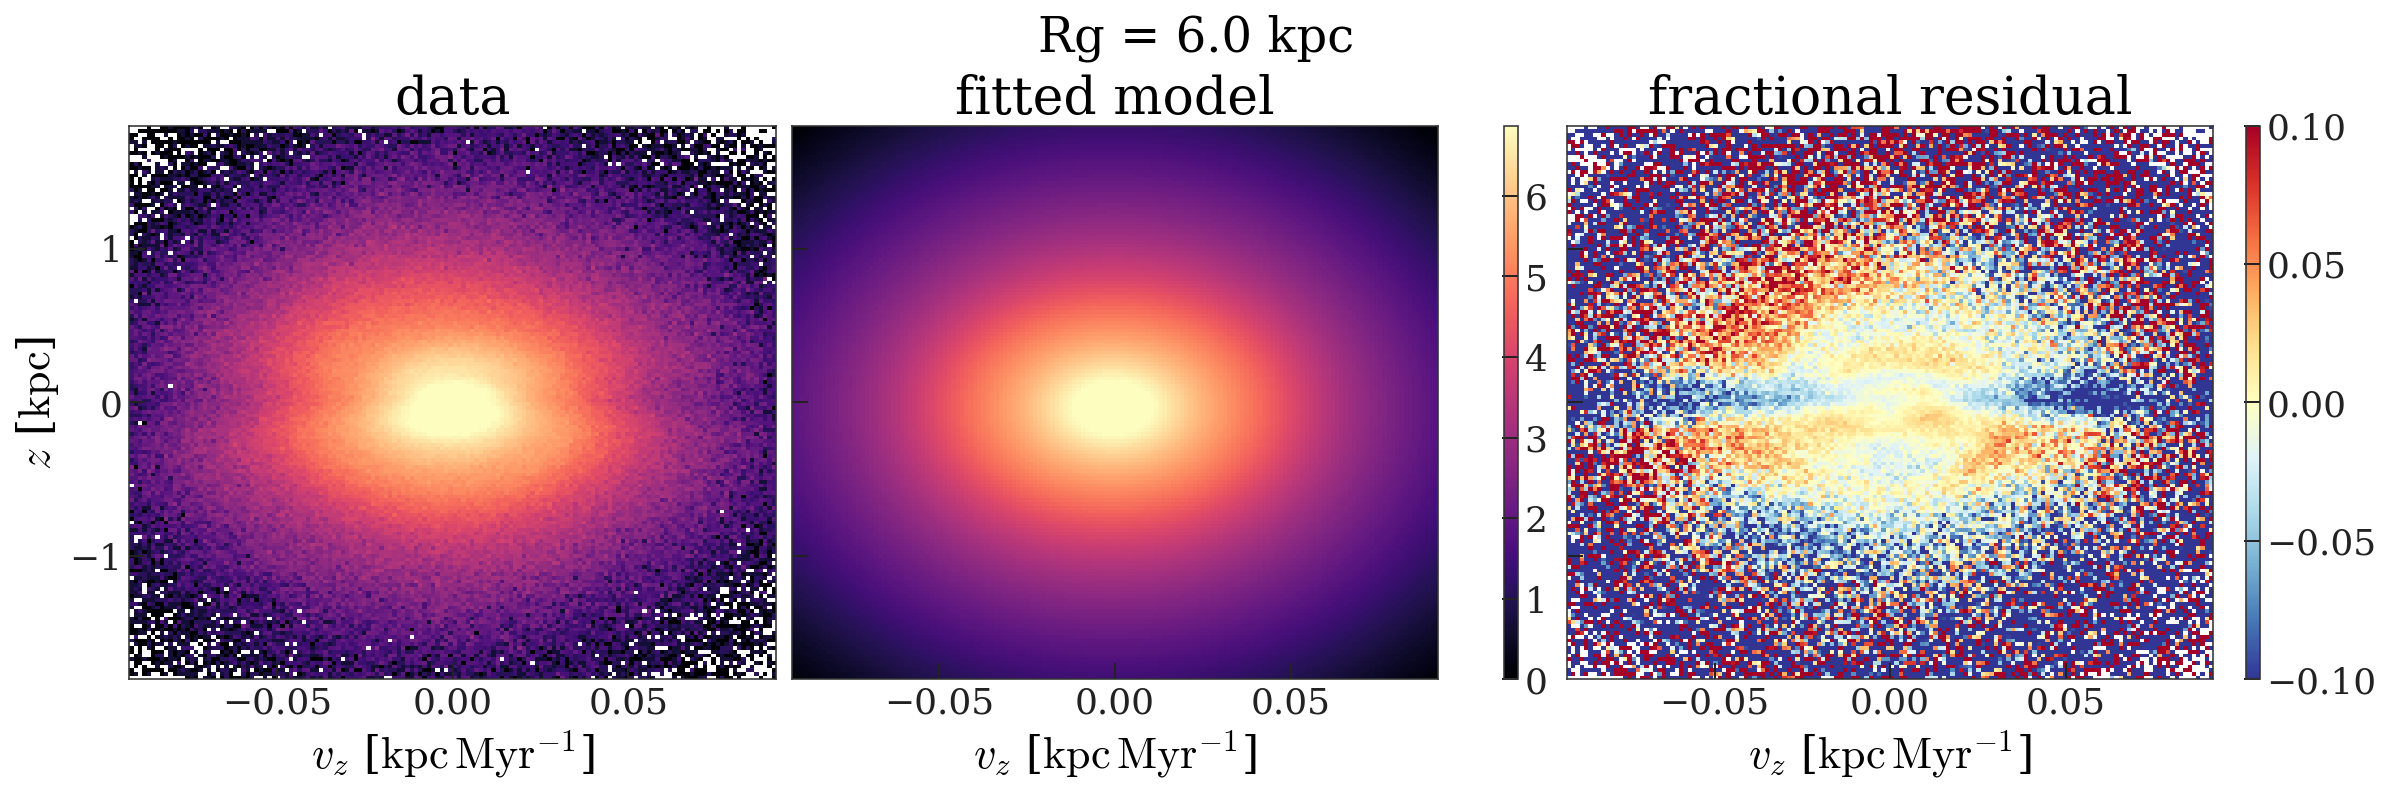

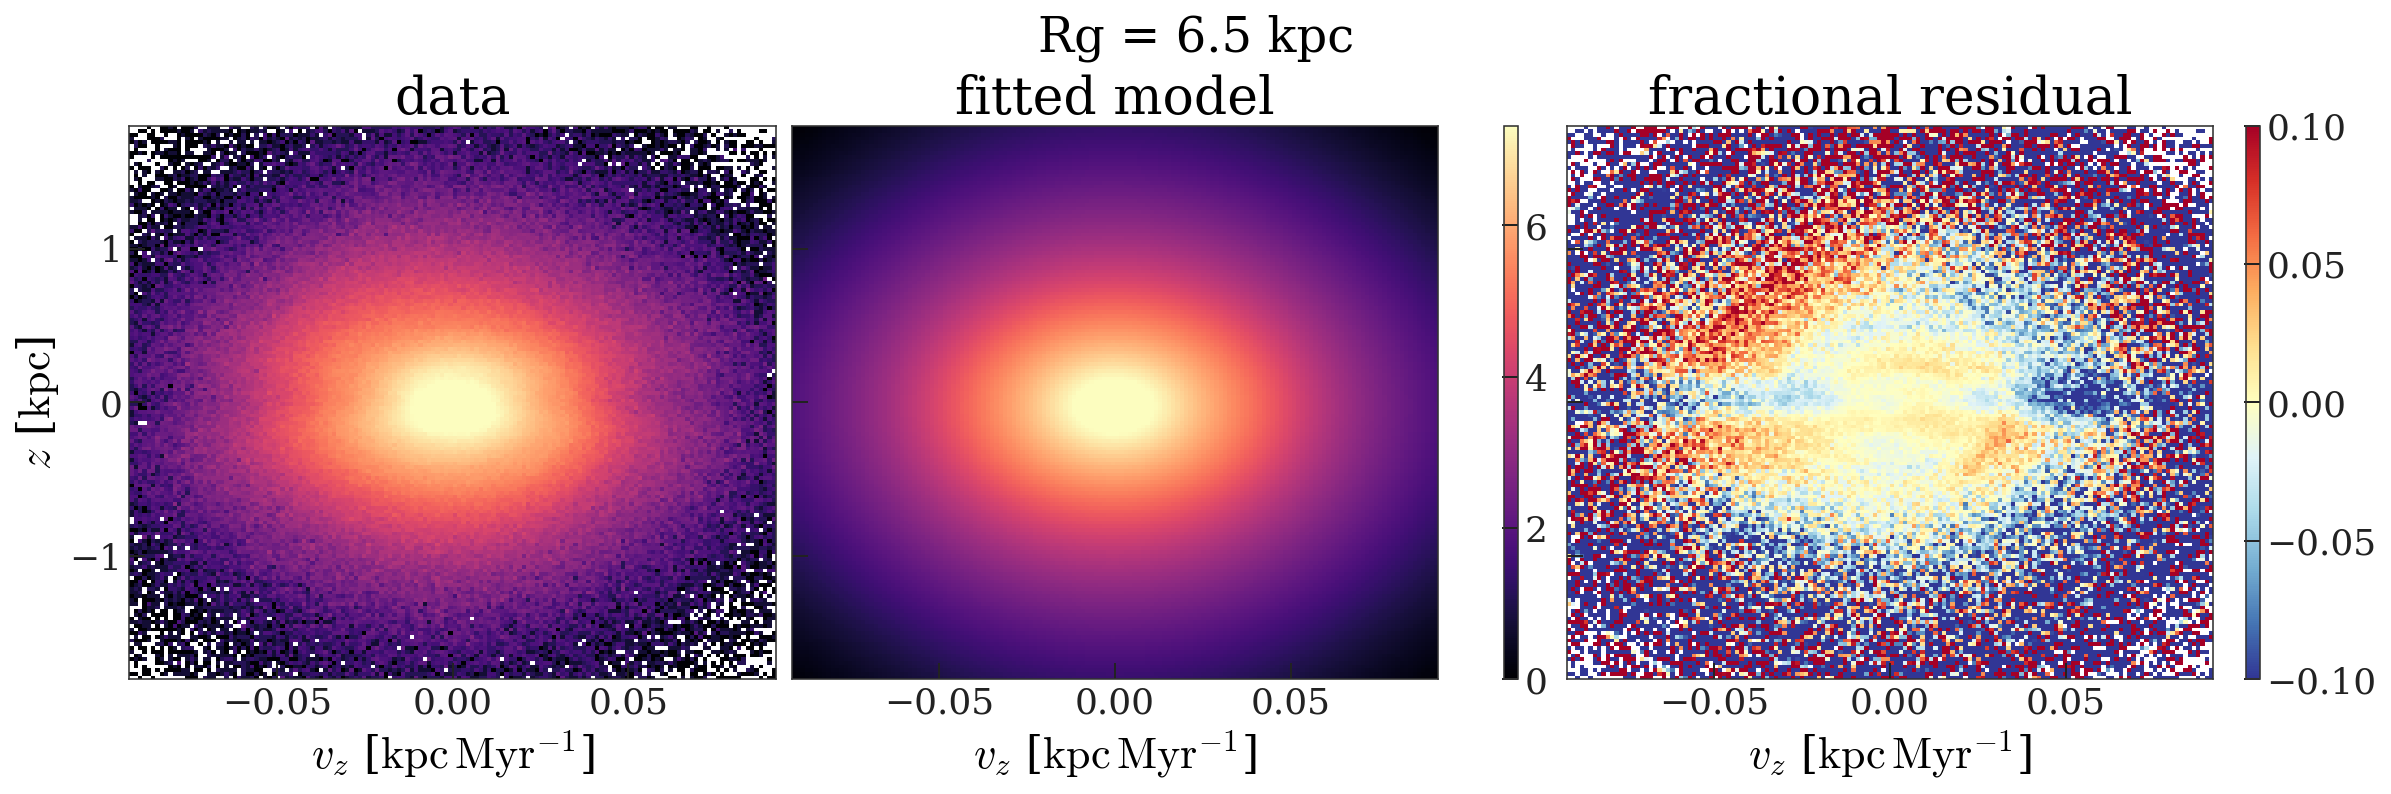

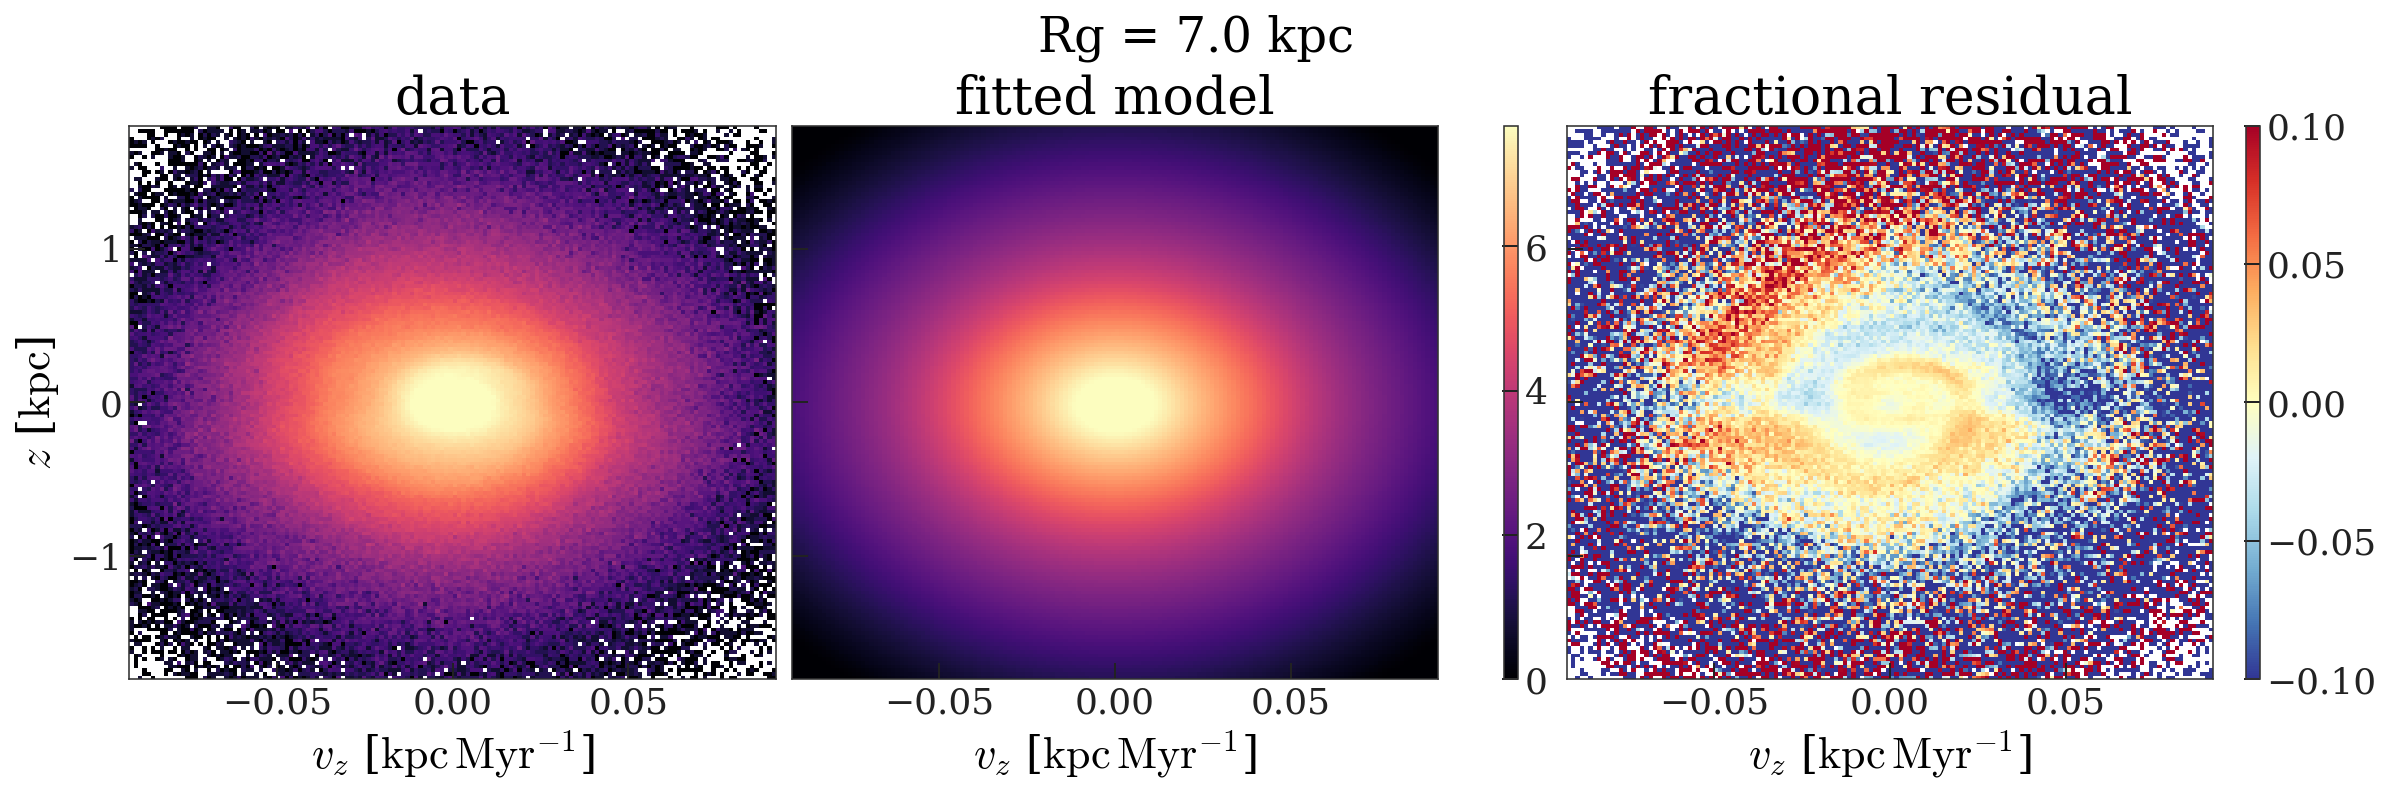

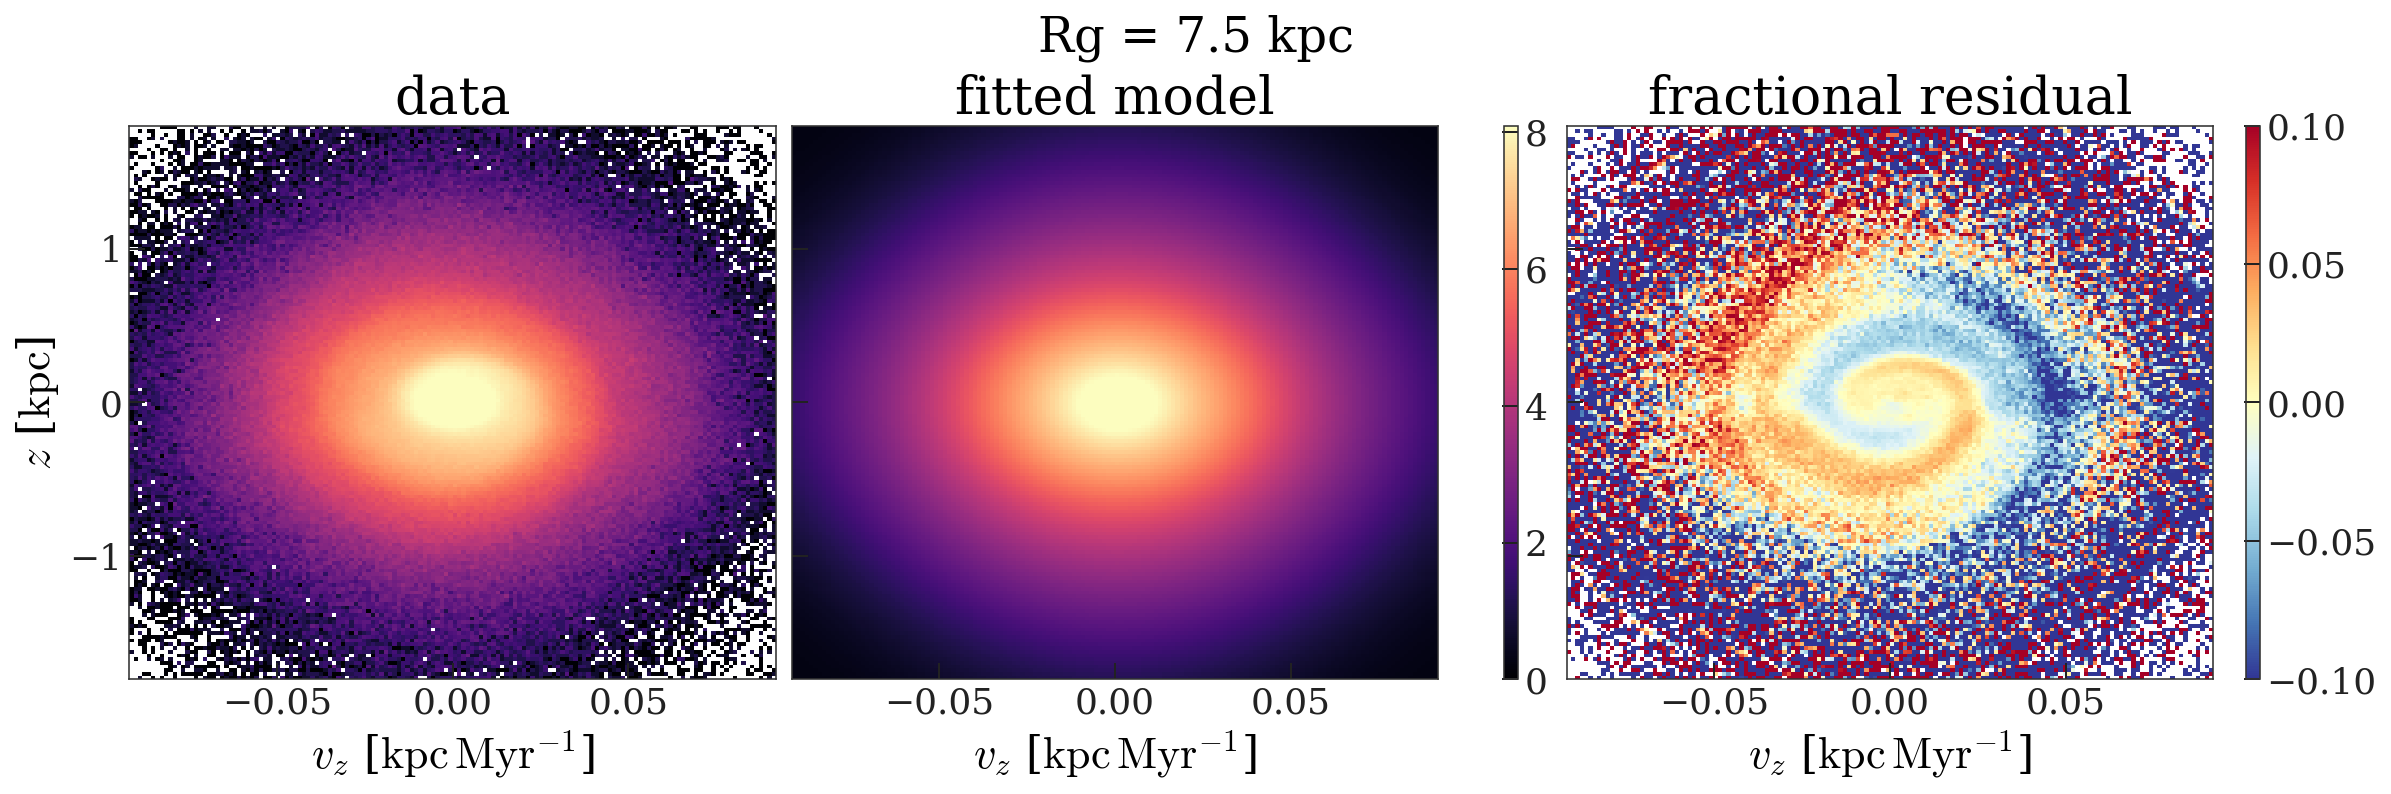

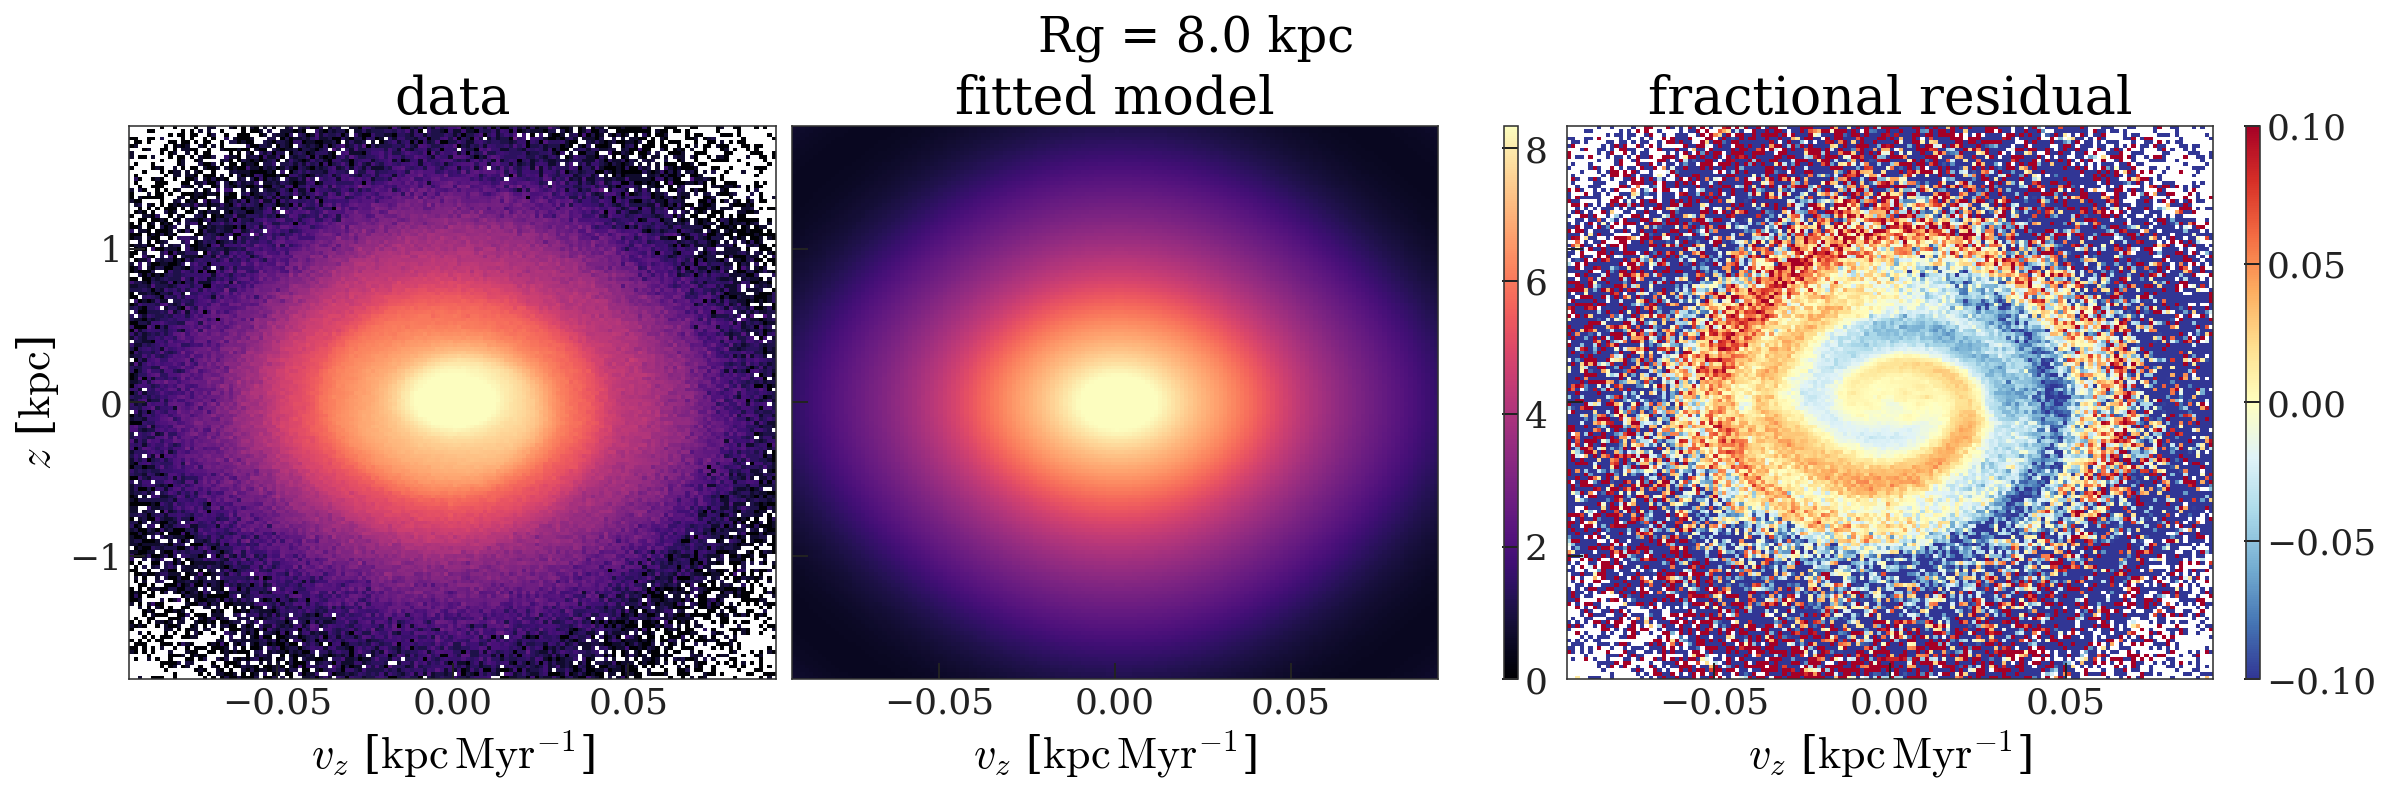

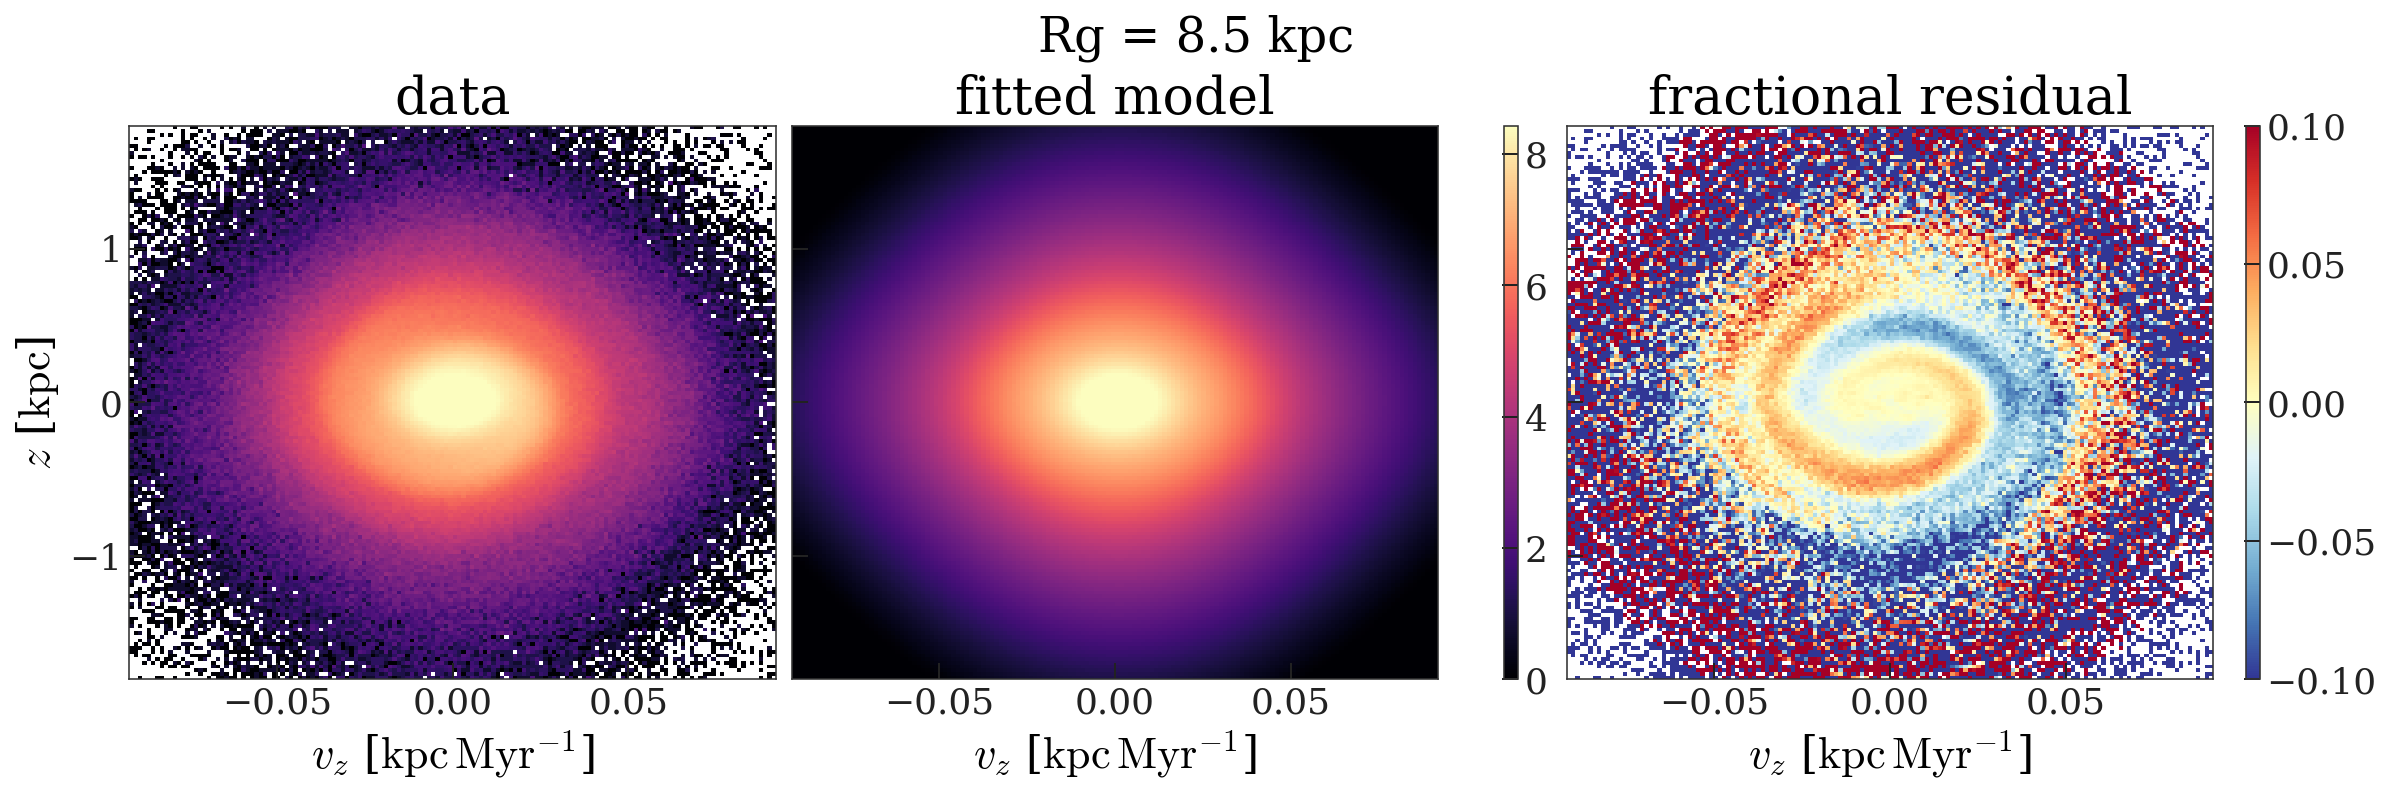

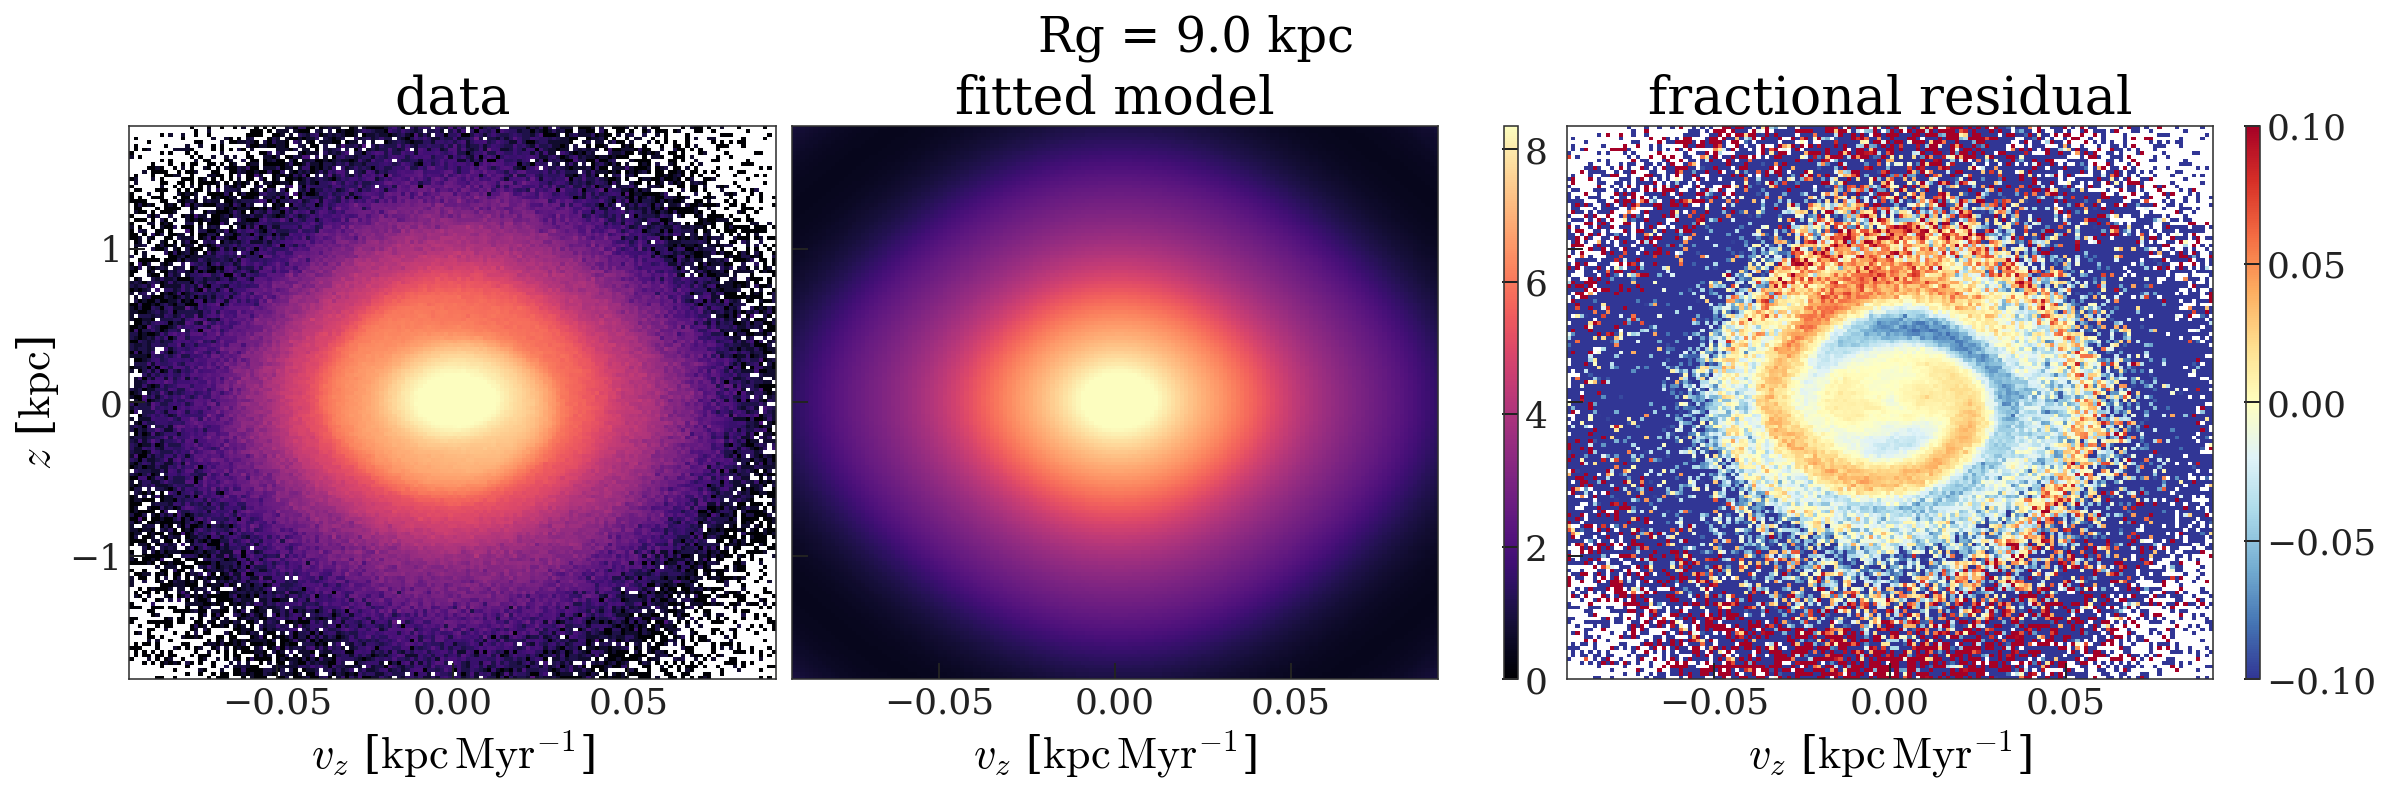

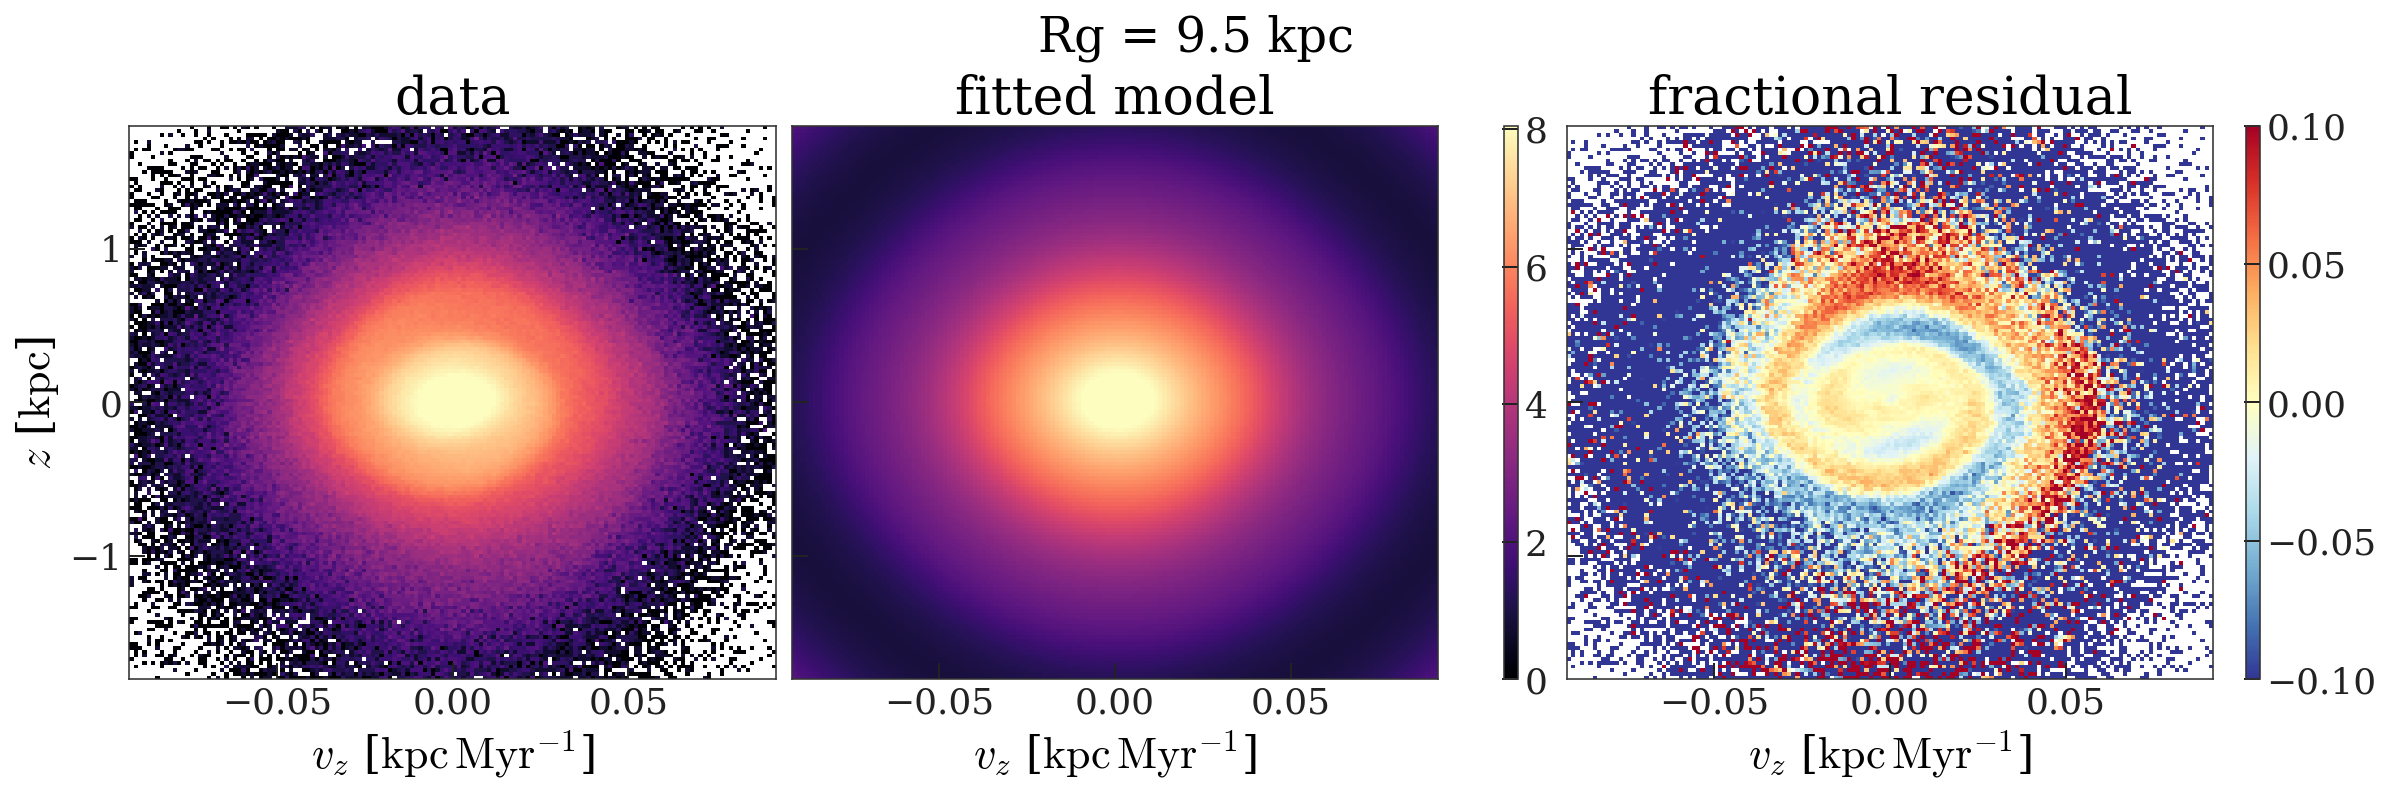

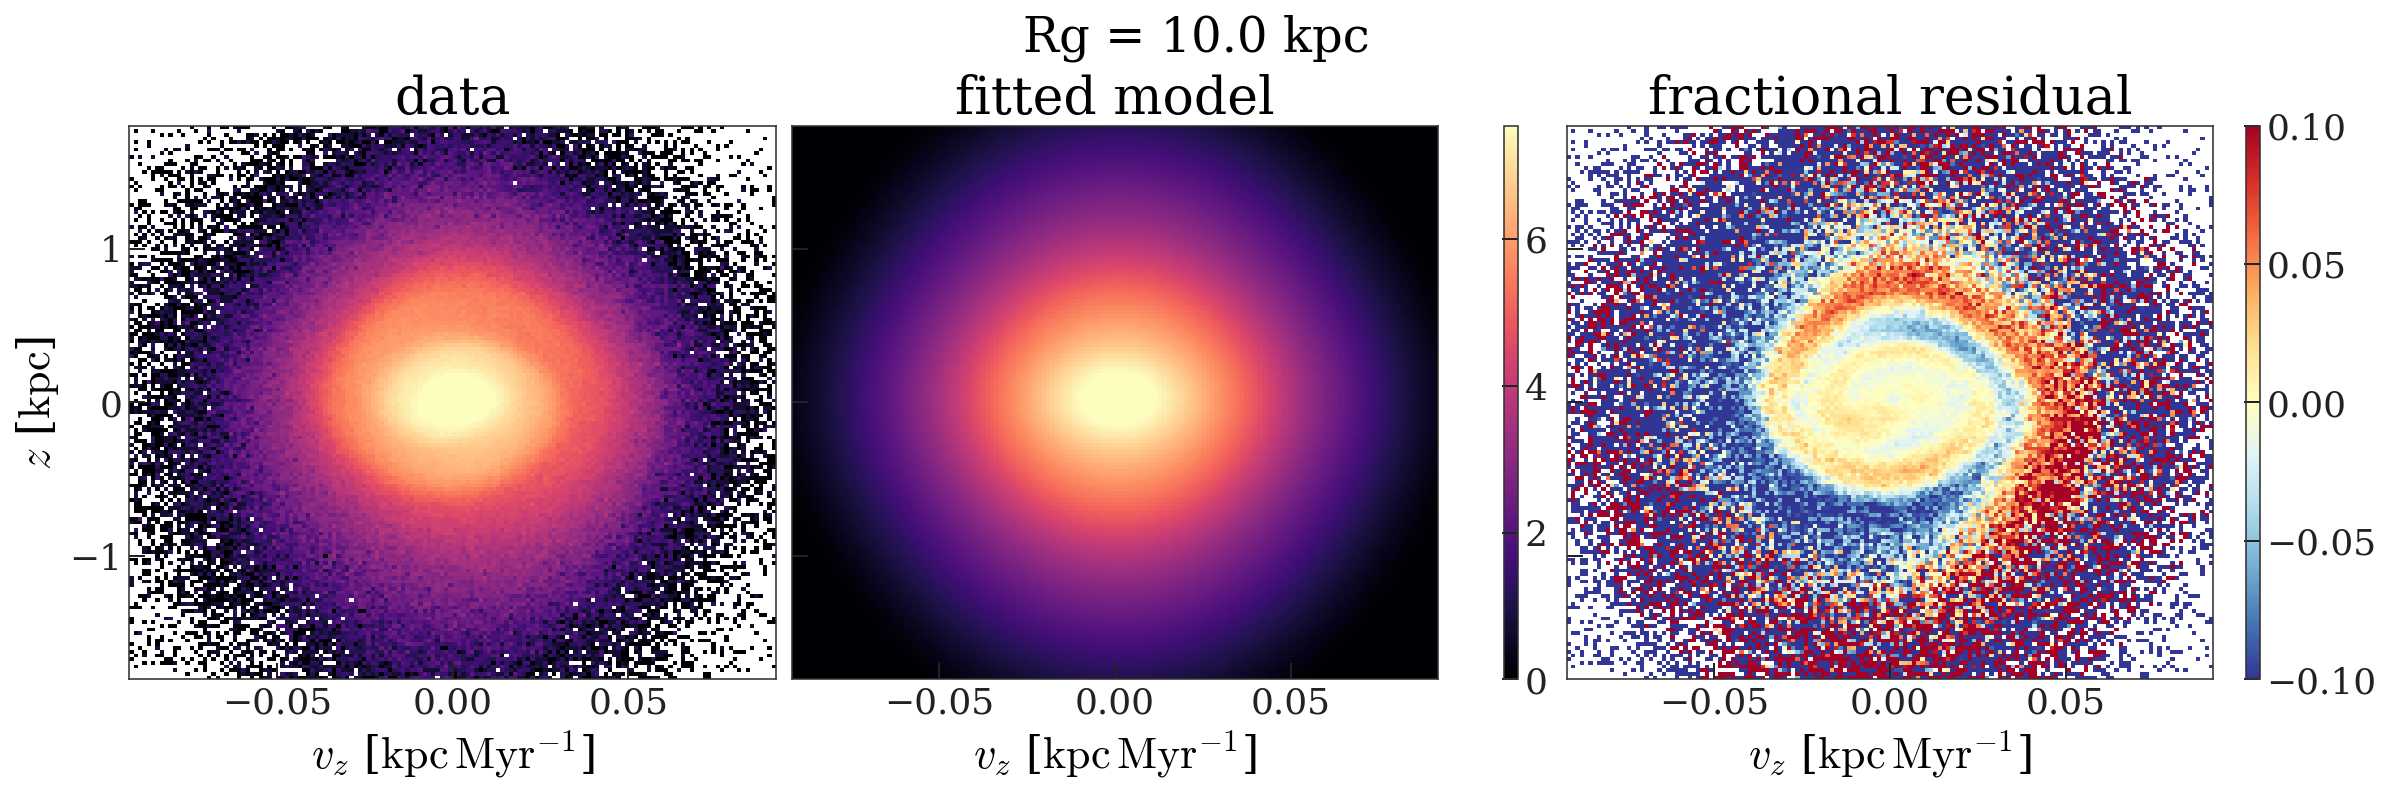

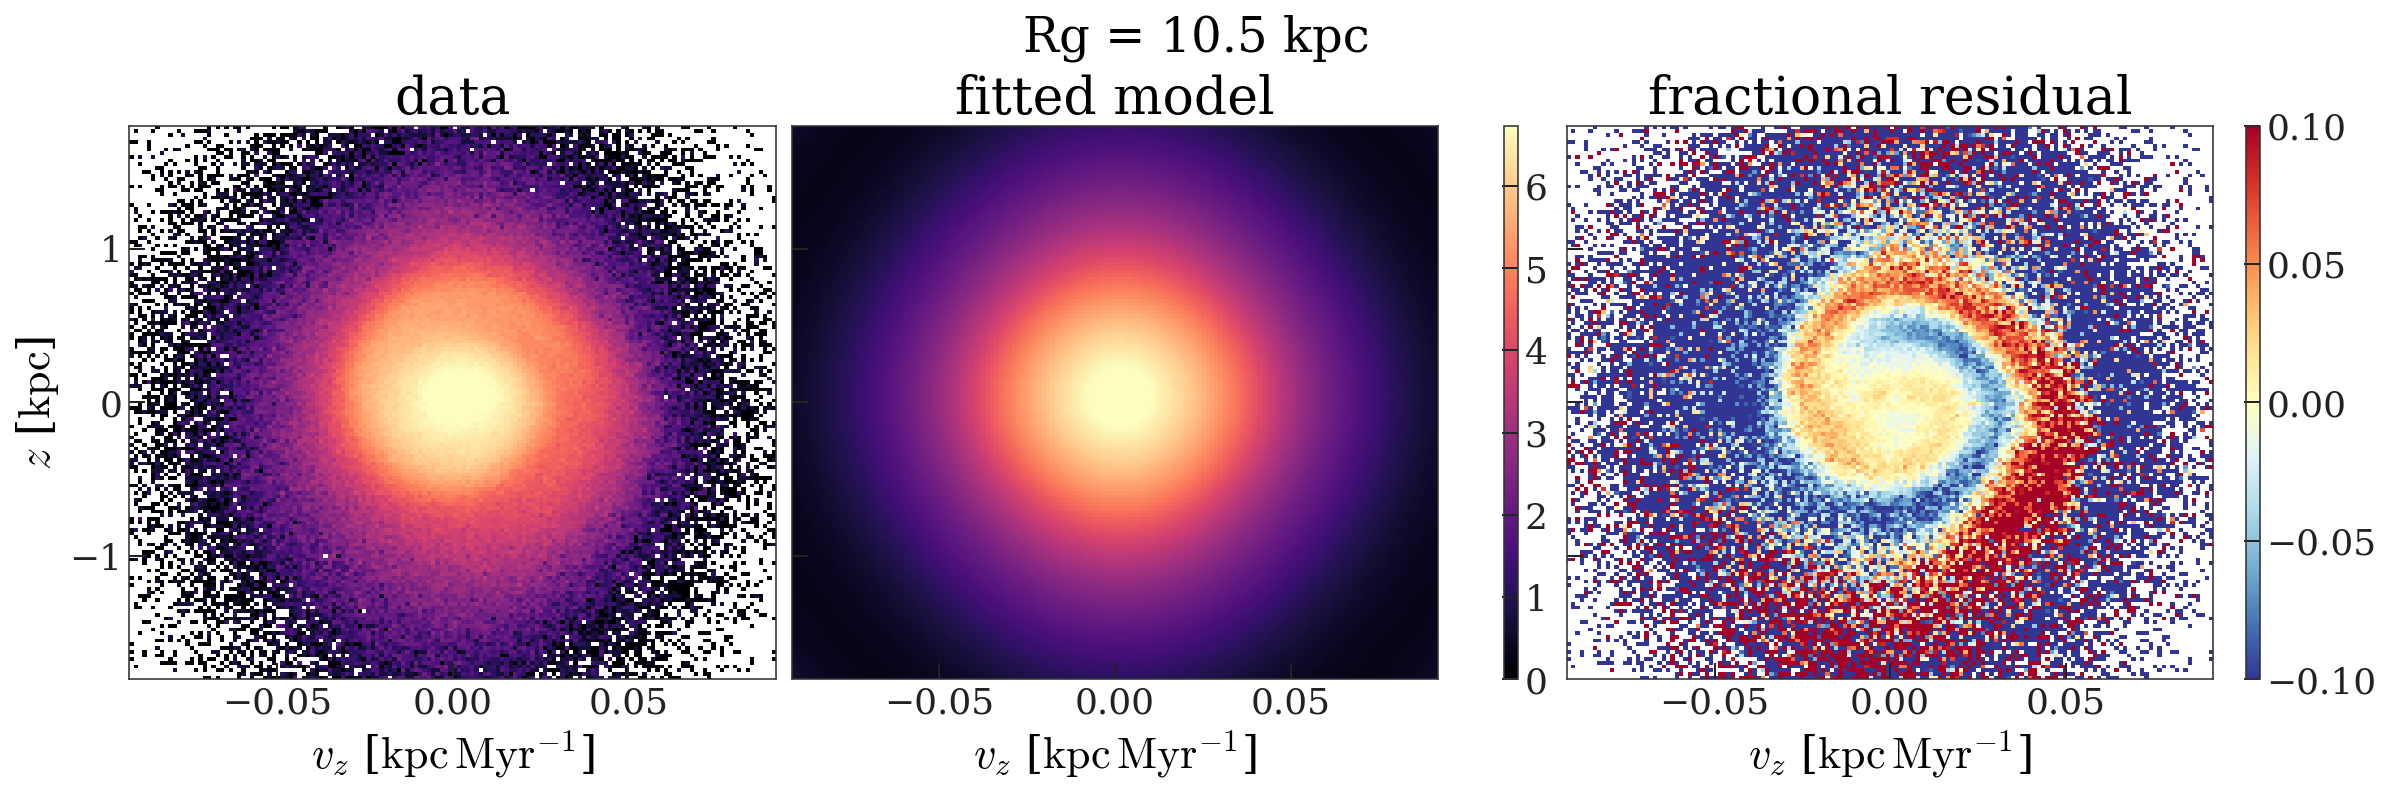

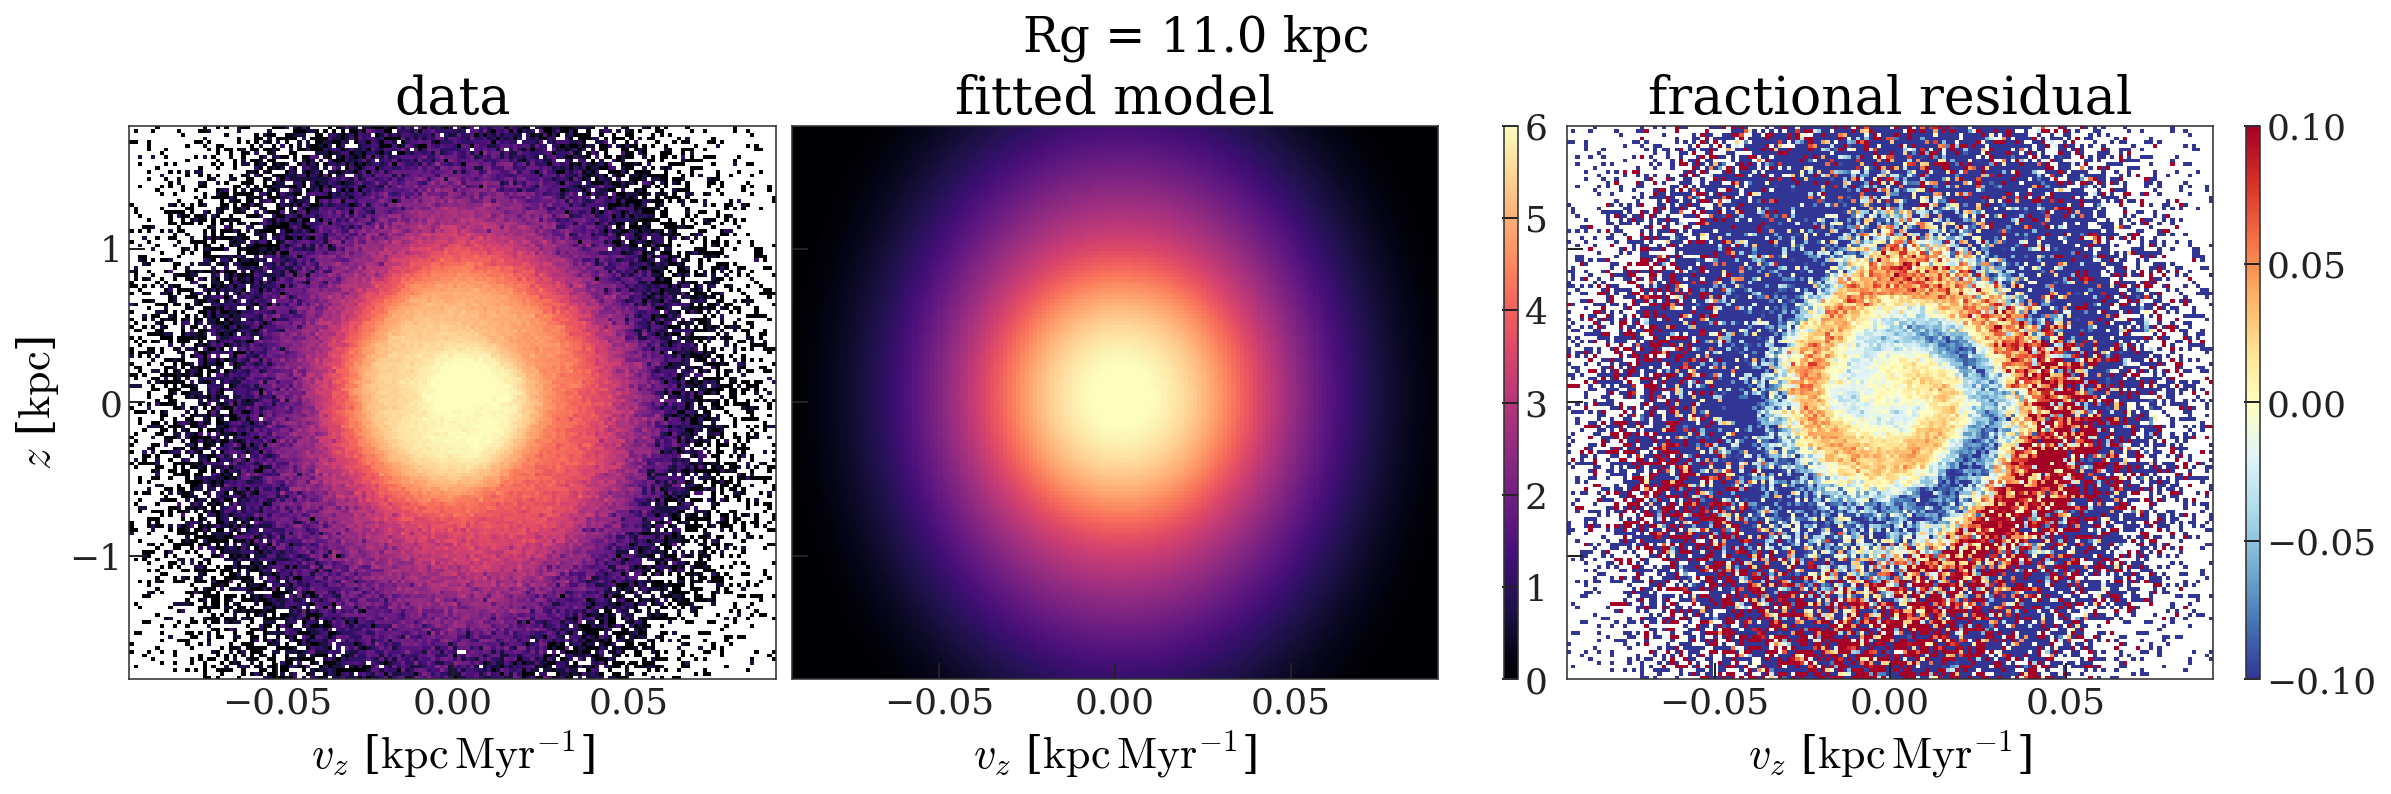

In [5]:
for i, Rg_c in enumerate(Rgs):
    model, res_params, bdata, _ = get_bin(i)

    # _ = plot_bdata(bdata)
    fig, axes = oti.plot.plot_data_models_residual(
        bdata, model, res_params, vlim_residual=0.1
    )
    fig.suptitle(f"Rg = {Rg_c:.1f}", fontsize=24)

In [6]:
max_z = bdata["pos"].max()

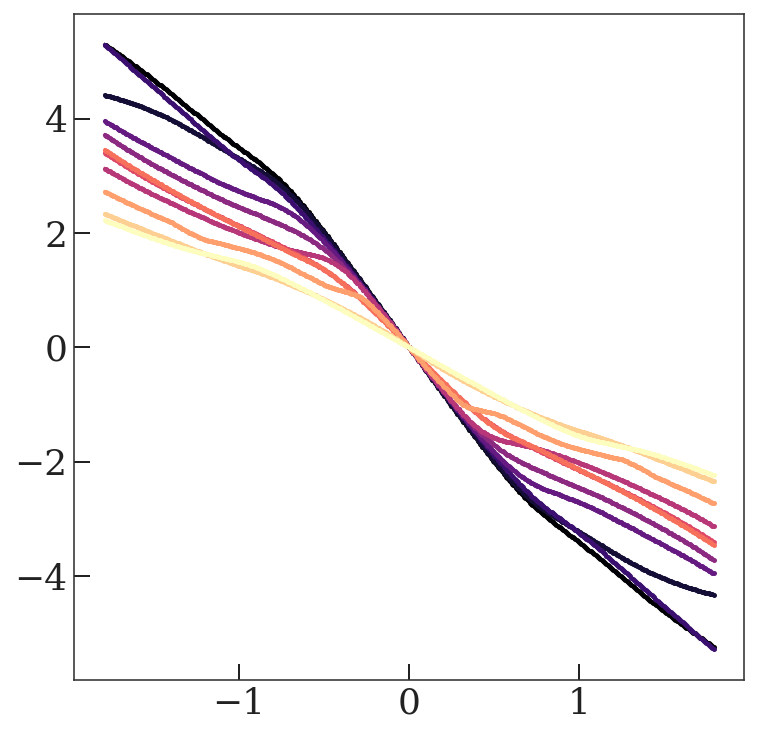

In [7]:
zgrid = np.linspace(-1, 1, 512) * max_z
a_unit = u.km / u.s / u.Myr

norm = mpl.colors.Normalize(Rgs.min().value, Rgs.max().value)
cmap = plt.get_cmap("magma")
for i, Rg_c in enumerate(Rgs):
    model, res_params, bdata, _ = get_bin(i)
    bestfit_acc = model.get_acceleration(zgrid, res_params).to(a_unit)
    plt.plot(zgrid, bestfit_acc.value, color=cmap(norm(Rg_c.value)))

In [8]:
all_aafs = []
for i, Rg_c in enumerate(Rgs):
    all_aafs.append(at.QTable.read(cache_path / f"gaia-spiral-{i}-aaf.hdf5"))

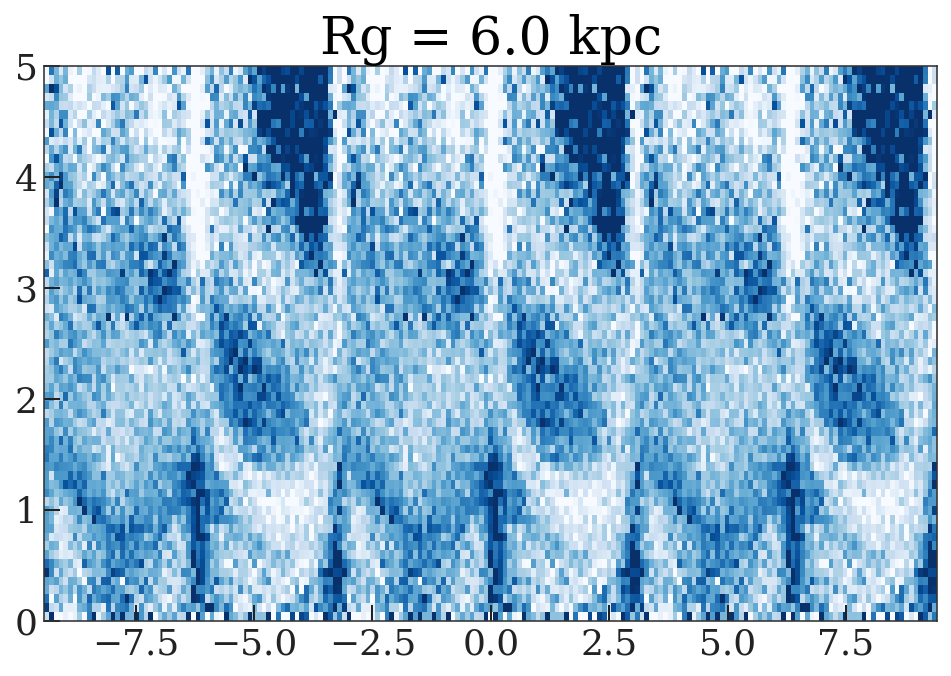

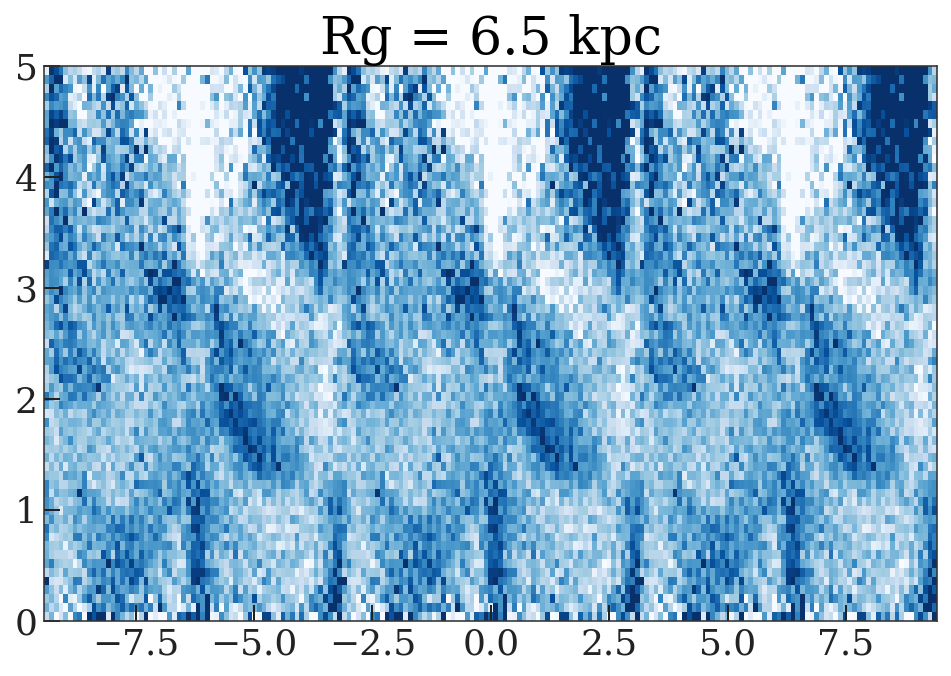

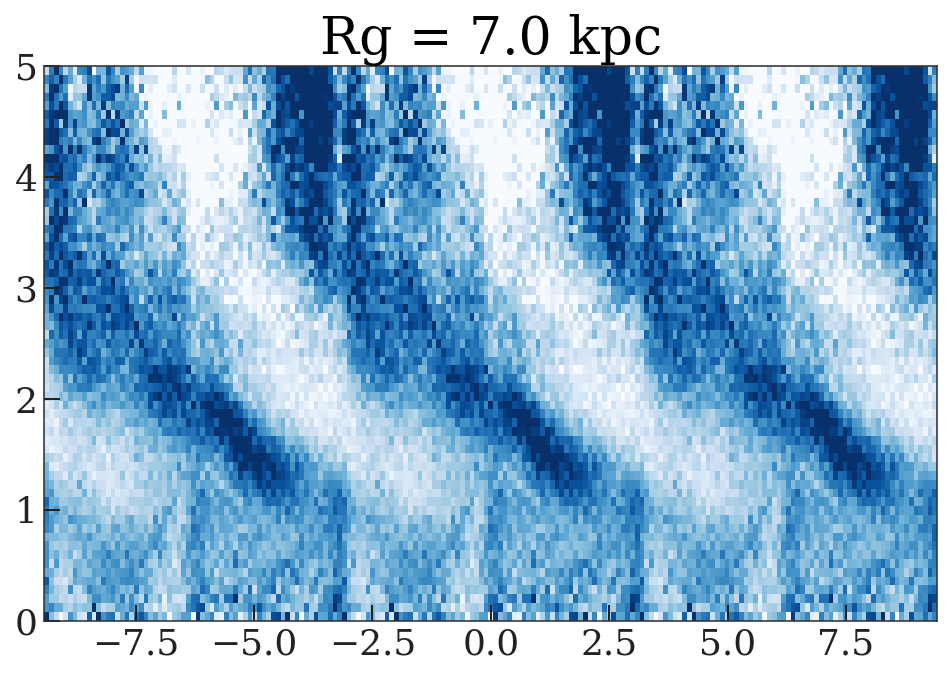

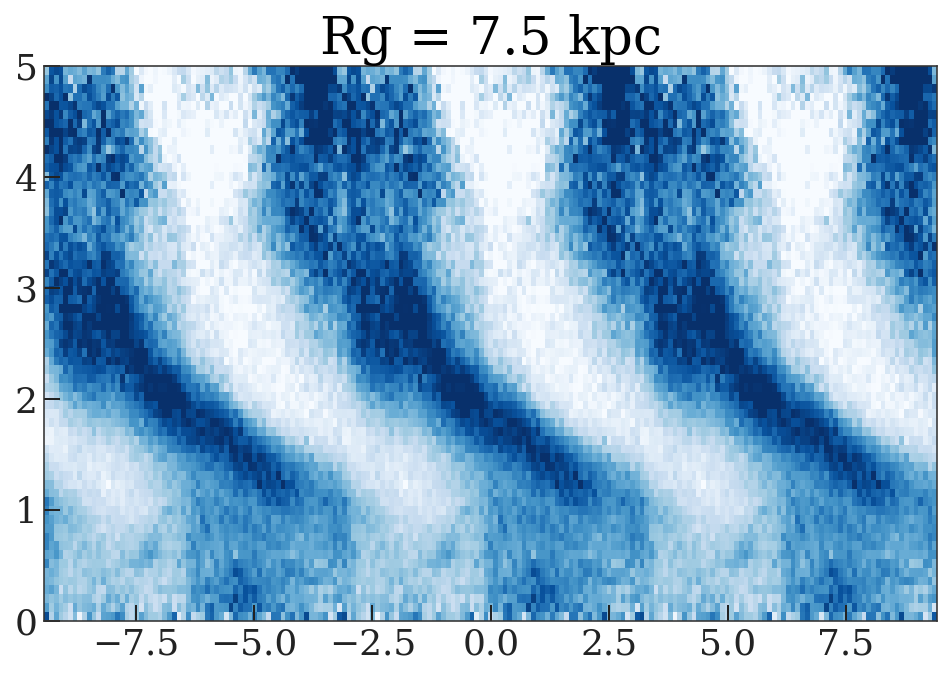

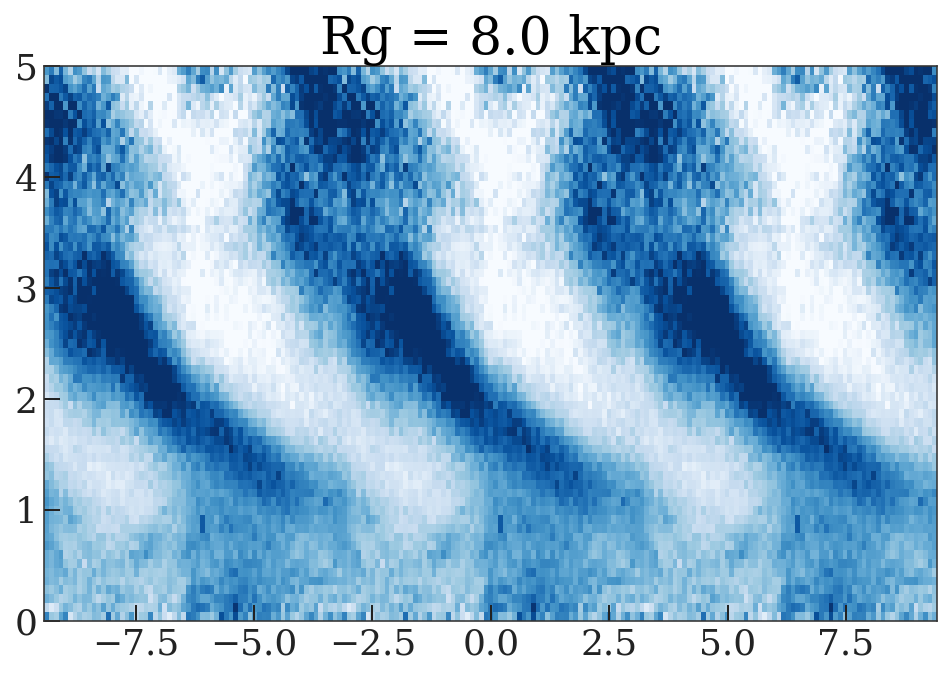

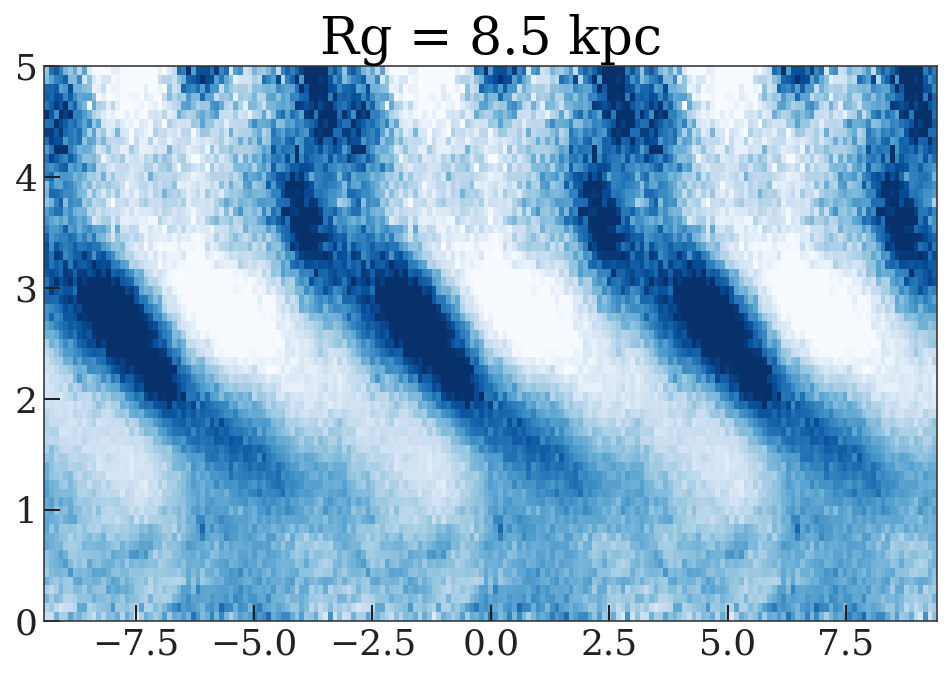

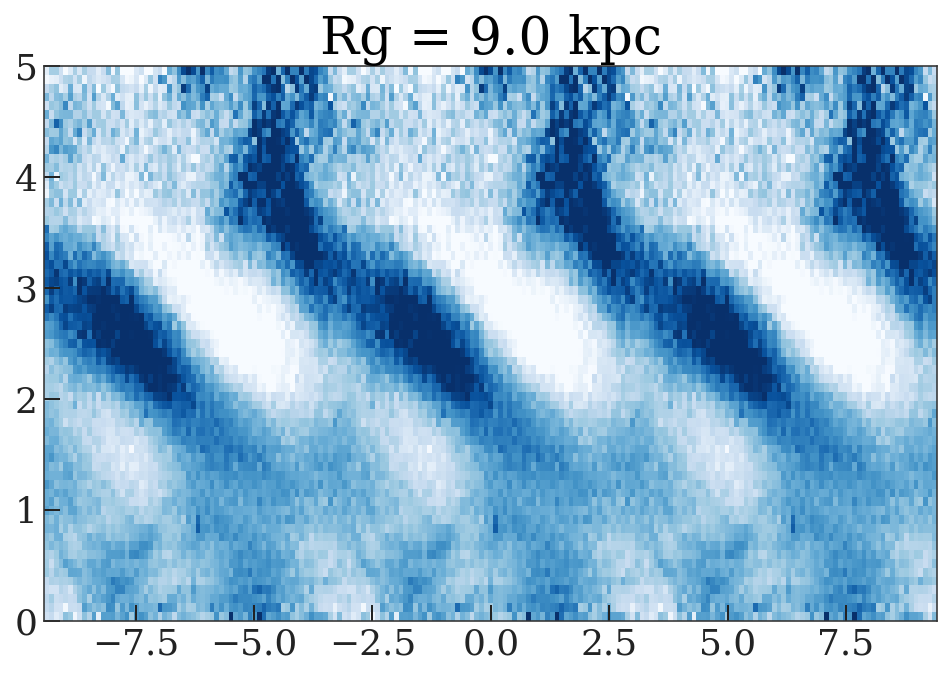

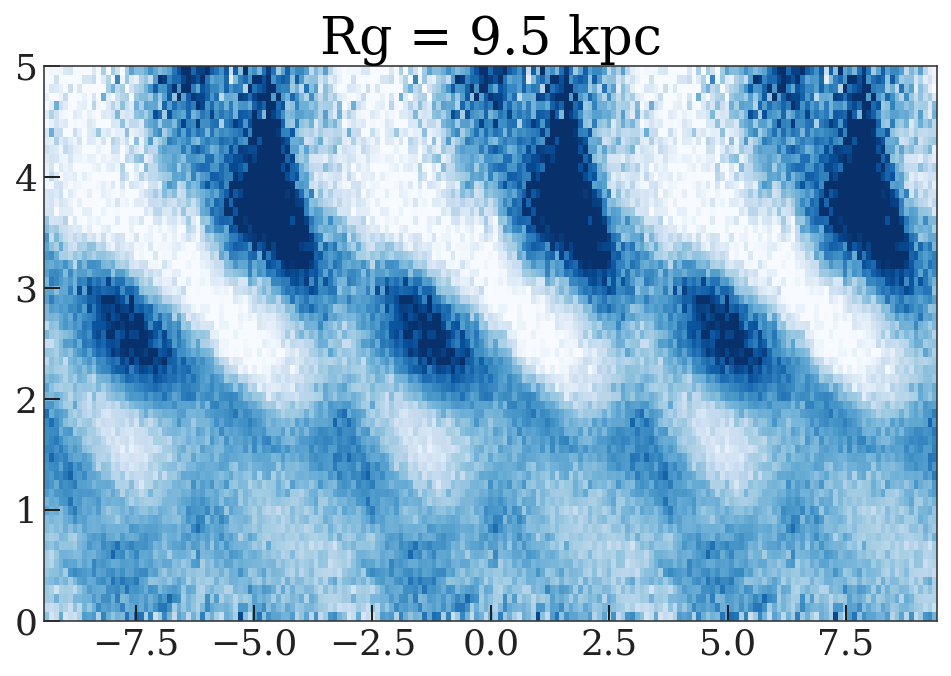

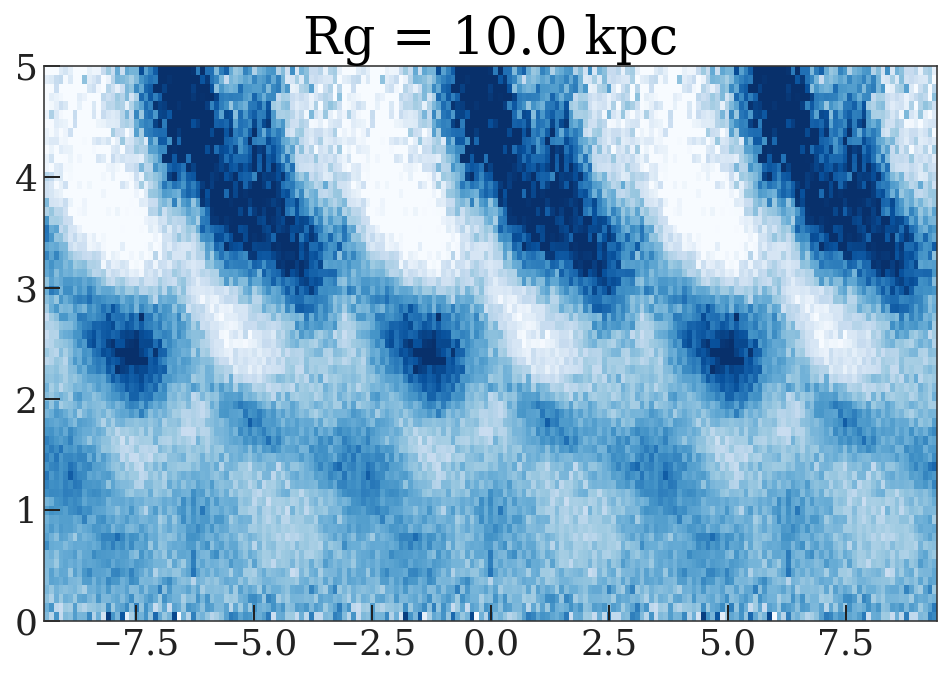

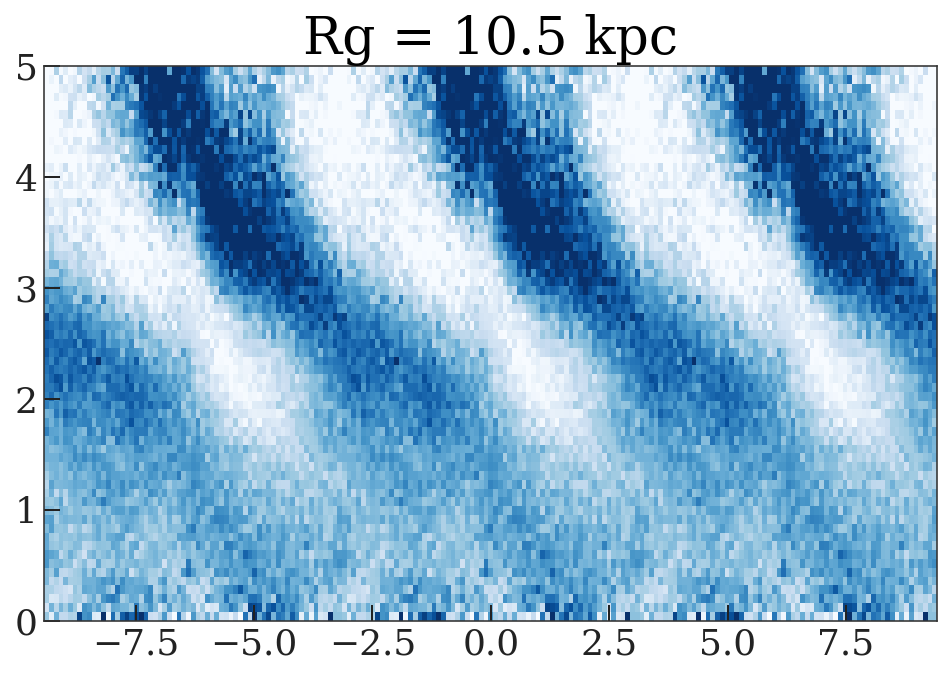

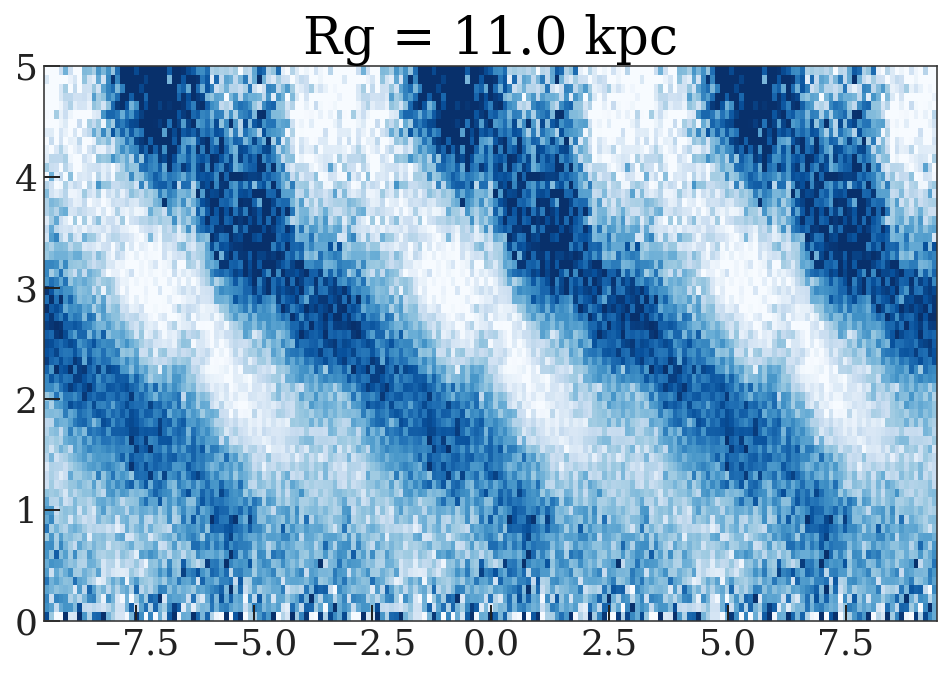

In [9]:
for i, Rg_c in enumerate(Rgs):
    aaf = all_aafs[i]

    zmax = np.sqrt(aaf["J"] / aaf["Omega"])
    H, xe, ye = np.histogram2d(
        aaf["theta"],
        np.sqrt((aaf["J"] * u.kpc**2 / u.Myr).to_value(u.kpc * u.km / u.s)),
        bins=(np.linspace(-np.pi, np.pi, 64), np.linspace(0, 5, 64))
        # zmax,
        # bins=(np.linspace(-np.pi, np.pi, 64), np.linspace(0, 1.0, 64)),
    )

    dH = H.T / H.T.sum(axis=0)[None]
    dH = (dH - dH.mean(axis=1)[:, None]) / dH.mean(axis=1)[:, None]
    vmin, vmax = np.nanpercentile(dH, [5, 95])
    kw = dict(cmap="Blues", vmin=vmin, vmax=vmax)

    plt.figure(figsize=(8, 5))
    plt.pcolormesh(xe - 2 * np.pi, ye, dH, **kw)
    plt.pcolormesh(xe, ye, dH, **kw)
    plt.pcolormesh(xe + 2 * np.pi, ye, dH, **kw)
    plt.title(f"Rg = {Rg_c:.1f}")

In [10]:
plot_Rgs = [7, 8, 9, 10, 11] * u.kpc

/tmp/ipykernel_1025686/3517137798.py:23: RuntimeWarning: divide by zero encountered in true_divide
  (np.exp(bdata["label"]) - np.exp(model_H)) / np.sqrt(bdata["counts"]),


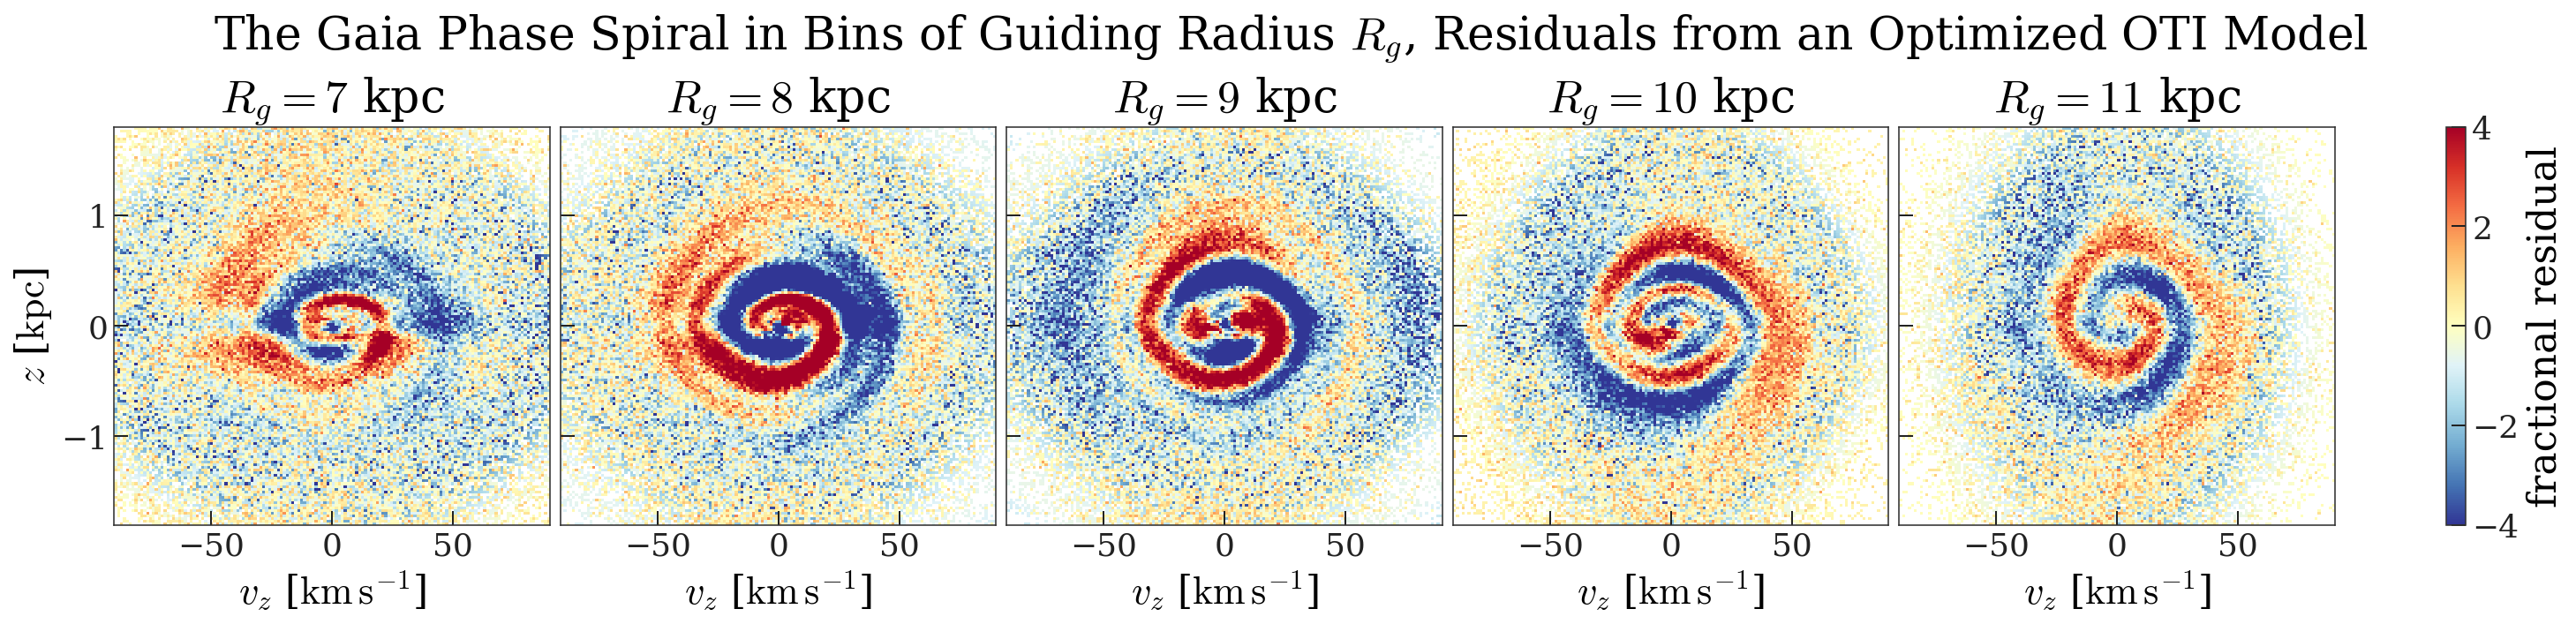

In [11]:
fig, axes = plt.subplots(
    1,
    len(plot_Rgs),
    figsize=(4 * len(plot_Rgs) + 0.2, 4.5 + 0.3),
    layout="constrained",
    sharex=True,
    sharey=True,
)

for j, plot_Rg in enumerate(plot_Rgs):
    ax = axes[j]

    i = np.where(Rgs == plot_Rg)[0][0]
    model, res_params, bdata, _ = get_bin(i)
    model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res_params)

    cs = ax.pcolormesh(
        bdata["vel"].to_value(u.km / u.s),
        bdata["pos"].to_value(u.kpc),
        # (np.exp(bdata["label"]) - np.exp(model_H)) / (bdata["counts"]),
        # vmin=-0.3,
        # vmax=0.3,
        (np.exp(bdata["label"]) - np.exp(model_H)) / np.sqrt(bdata["counts"]),
        vmin=-4,
        vmax=4,
        cmap="RdYlBu_r",
        rasterized=True,
    )
    ax.set_title(f"$R_g = {plot_Rg.value:.0f}$ kpc")

cb = fig.colorbar(cs, ax=axes)
cb.set_label("fractional residual")

for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")

fig.suptitle(
    "The Gaia Phase Spiral in Bins of Guiding Radius $R_g$, Residuals from an Optimized OTI Model",
    fontsize=26,
)

fig.savefig("../tex/figures/gaia-spiral-residuals.pdf", bbox_inches="tight", dpi=250)

Text(0.5, 0.98, 'The Gaia Phase Spiral in Bins of Guiding Radius $R_g$, Residuals from an Optimized OTI Model')

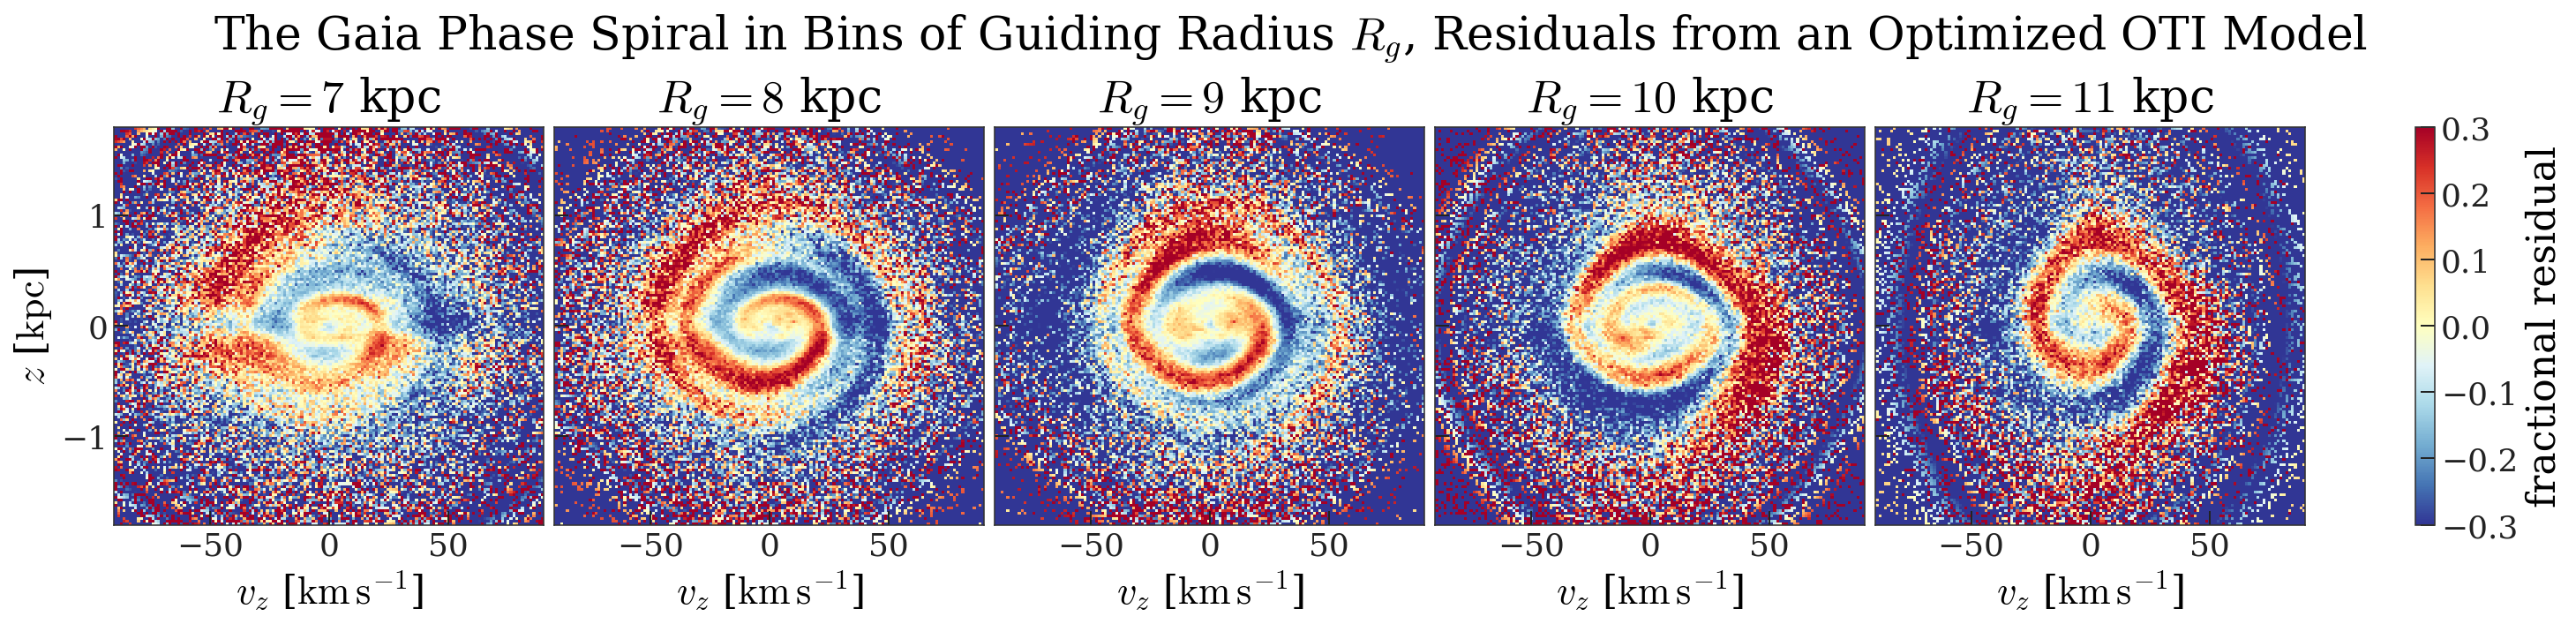

In [13]:
fig, axes = plt.subplots(
    1,
    len(plot_Rgs),
    figsize=(4 * len(plot_Rgs) + 0.2, 4.5 + 0.3),
    layout="constrained",
    sharex=True,
    sharey=True,
)

for j, plot_Rg in enumerate(plot_Rgs):
    ax = axes[j]

    i = np.where(Rgs == plot_Rg)[0][0]
    model, res_params, bdata, _ = get_bin(i)
    model_H = model._get_label(pos=bdata["pos"], vel=bdata["vel"], params=res_params)

    cs = ax.pcolormesh(
        bdata["vel"].to_value(u.km / u.s),
        bdata["pos"].to_value(u.kpc),
        (np.exp(bdata["label"]) - np.exp(model_H)) / np.exp(model_H),
        vmin=-0.3,
        vmax=0.3,
        cmap="RdYlBu_r",
        rasterized=True,
    )
    ax.set_title(f"$R_g = {plot_Rg.value:.0f}$ kpc")

cb = fig.colorbar(cs, ax=axes)
cb.set_label("fractional residual")

for ax in axes:
    ax.set_xlabel(f"$v_z$ [{u.km/u.s:latex_inline}]")
axes[0].set_ylabel(f"$z$ [{u.kpc:latex_inline}]")

fig.suptitle(
    "The Gaia Phase Spiral in Bins of Guiding Radius $R_g$, Residuals from an Optimized OTI Model",
    fontsize=26,
)

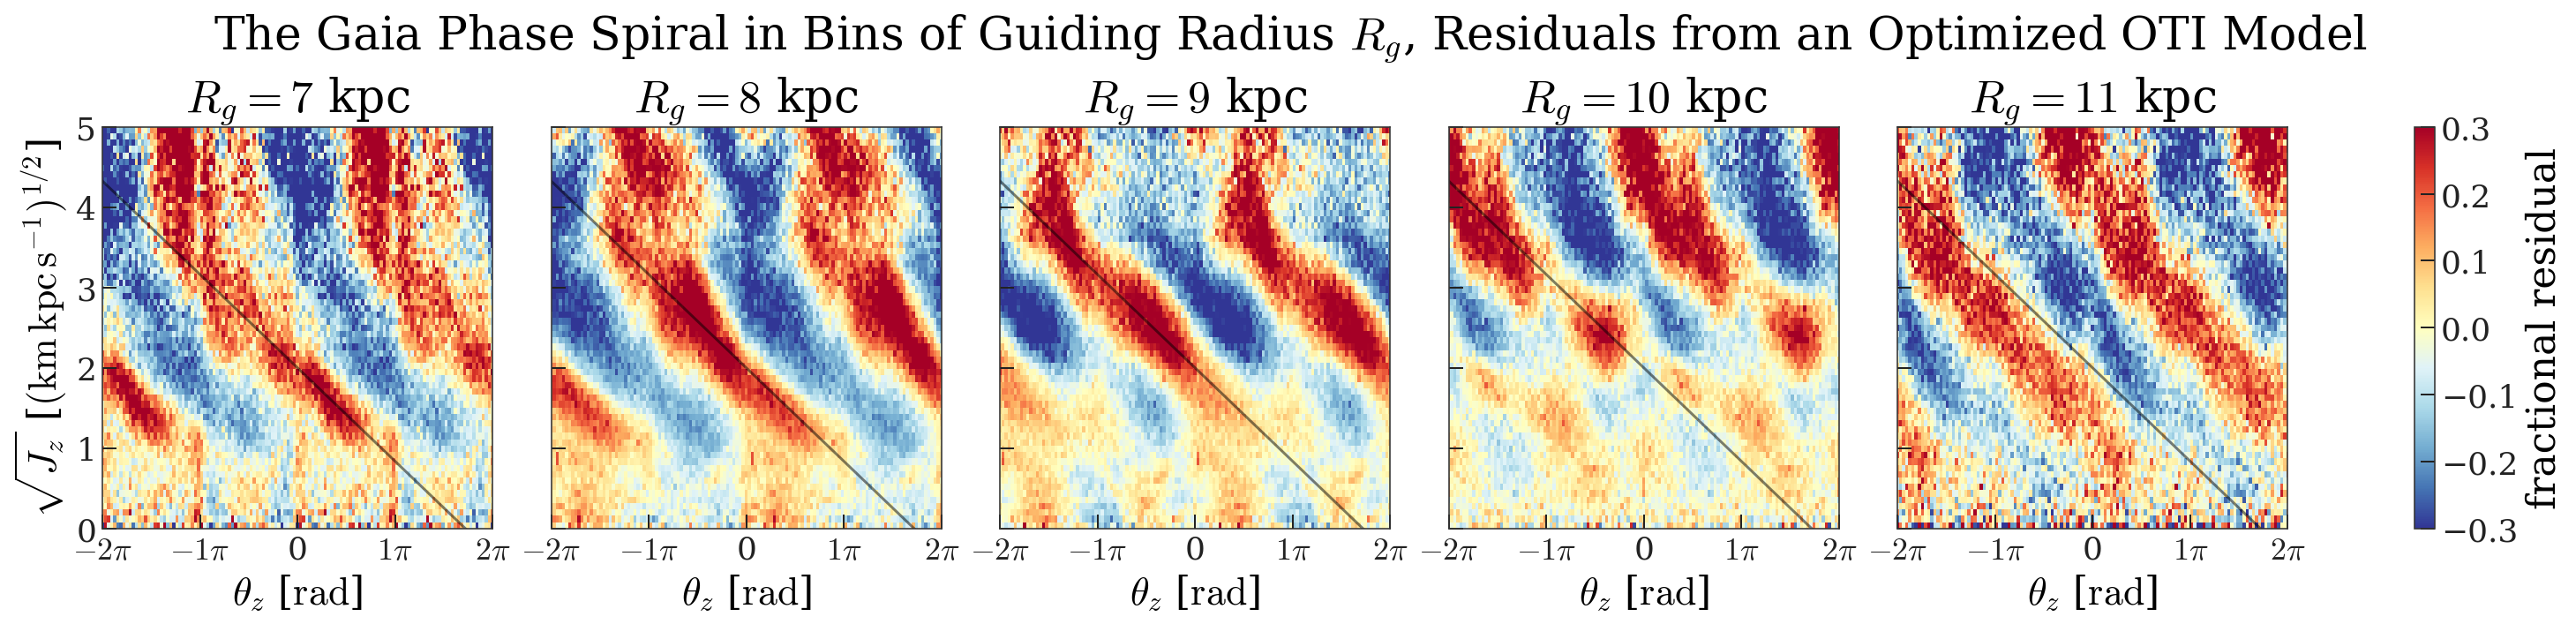

In [14]:
fig, axes = plt.subplots(
    1,
    len(plot_Rgs),
    figsize=(4 * len(plot_Rgs) + 0.2, 4.5 + 0.3),
    layout="constrained",
    sharex=True,
    sharey=True,
)

for j, plot_Rg in enumerate(plot_Rgs):
    ax = axes[j]

    i = np.where(Rgs == plot_Rg)[0][0]
    aaf = all_aafs[i]

    H, xe, ye = np.histogram2d(
        aaf["theta"],
        np.sqrt((aaf["J"] * u.kpc**2 / u.Myr).to_value(u.kpc * u.km / u.s)),
        bins=(np.linspace(-np.pi, np.pi, 64), np.linspace(0, 5, 64)),
        # zmax,
        # bins=(np.linspace(-np.pi, np.pi, 64), np.linspace(0, 1.0, 64)),
    )

    dH = H.T / H.T.sum(axis=0)[None]
    dH = (dH - dH.mean(axis=1)[:, None]) / dH.mean(axis=1)[:, None]
    vmax = np.max(np.abs(np.nanpercentile(dH, [5, 95])))

    kw = dict(cmap="RdYlBu_r", vmin=-vmax, vmax=vmax)

    for shift in [-2 * np.pi, 0, 2 * np.pi]:
        ax.pcolormesh(xe + shift, ye, dH, **kw)

    ax.set_title(f"$R_g = {plot_Rg.value:.0f}$ kpc")
    ax.set_xlim(-2 * np.pi, 2 * np.pi)

    tgrid = np.linspace(-2 * np.pi, 2 * np.pi, 1024)
    ax.plot(tgrid, -0.37 * tgrid + 2.0, marker="", color="k", alpha=0.5)
    ax.set_ylim(0, 5)

pi_ticks = np.arange(-2, 2 + 1e-3, 1.0)
ax.set_xticks(pi_ticks * np.pi)
ax.set_xticklabels([f"${t:.0f}\pi$" if t != 0 else "0" for t in pi_ticks])

cb = fig.colorbar(cs, ax=axes)
cb.set_label("fractional residual")

for ax in axes:
    ax.set_xlabel(r"$\theta_z$ " + f"[{u.rad:latex_inline}]")
axes[0].set_ylabel(
    r"$\sqrt{J_z}$ " + f"[$(${u.kpc * u.km/u.s:latex_inline}$)^{{1/2}}$]"
)

fig.suptitle(
    "The Gaia Phase Spiral in Bins of Guiding Radius $R_g$, Residuals from an Optimized OTI Model",
    fontsize=26,
)

fig.savefig("../tex/figures/gaia-spiral-zebra.pdf", bbox_inches="tight", dpi=250)